This is my "redesigned" analysis that I am creating based on my ideas from Australia. We will start by replotting the unfiltered data to get an idea of what it looks like. We will have barcode variant on the x-axis and barcode quantity on the  y-axis. The resulting plot should give us an idea of the "diversity" of the raw samples. Longer x-axis indicates greater richness, and greater consistency in the y-axis values indicates increased evenness. I am looking for both in order to proceed with the diversity and similar indices. 

## Importing Packages

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import fnmatch
import matplotlib.backends.backend_pdf
import glob
import numpy as np
import csv
import itertools
import shutil
import scipy
import re
import sys
import seaborn as sb
from functools import reduce
import statistics

# README

This script takes multiple steps to help analyze barcode analysis files. In the README, I will describe what should be done before you use this script, as well as how you should name your files to accommodate the script. 

Before you use this script: 

-You should identify all of the reads that you will be using for this process. 
-You should then trim your barcodes to a trim quality of 15. 
-Finally, you should use the barcode virus analysis script written by Brandon Keele to analyze your data. 
-The first input to this script will be the files that you get out from the barcode analysis virus script, which are    csv files. 

What should your data look like? 

You should have a directory for the entire analysis. Name it whatever you like, but it should include the name of the data set and what this directory is for (i.e. IV_Data_Analysis). You should NOT use spaces or strange characters in these names under ANY circumstances. You should find the "absolute path" for this folder, and paste it into the appRoot variable in the variable block below. If you don't know what an absolute path is, it is the full path to that specific directory. It can be found using the command "pwd" in the terminal once you navigate into your folder that the analysis will be done in.

Within your appRoot directory, you should have a list of folders that are named IDENTICAL to this: 

BackgroundInformation
Scripts
Step1.AllRawReads
Step2.FilterForReadsWithBarcodes
Step3.TrimmingBarcodeReads
Step4.BarcodeAnalysis
Step5.SplittingBarcodeAnalysisOutputFiles
Step6.CreatingSummarySpreadsheets
Step7.CalculatingSDI
Step8.SDI
Step9.Morisita-Horn
Step10.CategoricalScatterPlots

This code will jump in and start at step 4. Everything else before this point will be done manually by you. But the Step 4 directory should have a bunch of csv files that were output from the barcode virus analysis script. They should be labeled like this: 

trimmed_cy0428_Day_03_#1.fastq.gz_Barcode Analysis_Cutoff.csv

trimmed_cy0428_Day_14_#2.fastq.gz_Barcode Analysis_Cutoff.csv

It is VERY IMPORTANT to keep the formatting exactly the same as these files. This is because the code will later infer graph axis labels and headers based on these file names. 

"trimmed_" --> this is added to the beginning when you trim the file, you can leave it

"cy0428" --> this is the animal name. It should be custom to your animals, and length of the name doesn't matter, but it needs to be separated from trimmed and Day by an underscore. 

"Day_03" --> This should be the day. DO NOT put weeks, months, etc. Every single time point should be in days. It should also have the same amount of "sig figs" as the largest time point. If you have up to day 84, for example, every single day should have 2 digits. Day 3 should be day 03, etc. You also need to separate Day and the number by an underscore

"#1" --> This is the replicate number. Keep it in this exact format. 

Keep the rest of the name in this exact format. 


What will happen once you start running the script? 

First, you should make sure to change all of the variables in the beginning to whatever is relevant to your data. You should only have to do this in this first portion. If you cannot format the names like it shows above, you may need to change the code. This can be done by me, or by you as well if you know what to change. But if you can format the names like I mention, you will have an easier time running the rest of the script. 

You should not have to modify anything once you start running the script, except where the script mentions that you can or should make modifications. You should however stop and make sure everything is working correctly after every block, as these should be seen as checkpoints throughout the analysis process. 

# Defining Global Variables: User Input Necessary

Users should edit everything in green or red writing in this box to match that of their individual files. 

In [2]:
%matplotlib inline



######IV ANIMALS########

#appRoot = "/Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis"

#animal1name = "cy0428"

#animal2name = "cy0575"

#numsamples_animal1 = 11

#numsamples_animal2 = 8

#color = 'b'


######IR ANIMALS########

appRoot = "/Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146"

animal1name = 'r10001'

animal2name = 'r04103'

numsamples_animal1 = 15

numsamples_animal2 = 16

color = 'r'


# Pre-Defined Variables: No User Input Necessary

These are variables that do not have to be edited by the user, unless you feel it is important or necessary for your particular files. Otherwise, they will fall back on these default names.

In [3]:
#FOLDER NAMES

trimmedReads = appRoot + "/Step3.TrimmingBarcodeReads"

rawBarcodes = appRoot + "/Step4.BarcodeAnalysis"

splittingBarcodeAnalysisOutputDirectory = appRoot + "/Step5.SplittingBarcodeAnalysisOutputFiles"

summarySpreadsheetDirectory = appRoot + "/Step6.75.AllReplicatesToBeUsed"

sdiDirectory = appRoot + "/Step7.CalculatingSDI"

sdiFinalSpreadsheets = appRoot + "/Step8.SDI"

mhFolder = appRoot + "/Step9.Morisita-Horn"


#REPLICATES FOR THE REFERENCE AND EXPERIMENTAL SAMPLING STEPS 

replicates = 10


#STATISTICS SPREADSHEETS

animal_1_folders = glob.glob(summarySpreadsheetDirectory + "/" + animal1name + "*")

animal_2_folders = glob.glob(summarySpreadsheetDirectory + "/" + animal2name + "*")


#MORISITA-HORN FILES

animal1MH = mhFolder + "/MHmatrix" + animal1name + ".csv"

animal2MH = mhFolder + "/MHmatrix" + animal2name + ".csv"

# SPREADSHEET HANDLING AND FILE MANIPULATION

# Creating Necessary Directories

This portion of the code makes all of the necessary directories for you to properly run this code. 

In [ ]:
def making_directories():    
    if not os.path.exists(splittingBarcodeAnalysisOutputDirectory):
        os.makedirs(splittingBarcodeAnalysisOutputDirectory)
    
    if not os.path.exists(summarySpreadsheetDirectory): 
        os.makedirs(summarySpreadsheetDirectory)
        
    if not os.path.exists(experimental_permutation): 
        os.makedirs(experimental_permutation)
        
    if not os.path.exists(sdiDirectory): 
        os.makedirs(sdiDirectory)
        
    if not os.path.exists(sdiFinalSpreadsheets): 
        os.makedirs(sdiFinalSpreadsheets)
        
    if not os.path.exists(mhFolder): 
        os.makedirs(mhFolder)
        
    if not os.path.exists(cat_scatter_plot_directory):
        os.makedirs(cat_scatter_plot_directory)
        
directories = making_directories()

   # Copying Files To Splitting Barcodes Directory

This portion of the script will copy everything from the barcode analysis directory and copy it into the splitting barcodes directory so we can run the next portion of the script, which splits these files into two parts. We want to copy these files into a new directory instead of using the old directory because we want to save the original files. 

In [219]:
def moving_barcode_analysis_files(): 
    
    barcodes = os.listdir(rawBarcodes)
    destpath = splittingBarcodeAnalysisOutputDirectory
    for f in barcodes:
        shutil.copy(rawBarcodes + "/" + f, destpath)
            
moving_files = moving_barcode_analysis_files()

# Splitting Barcode Analysis Output Files

This is the first step in the post-barcode analysis pipeline. It will take the output files and split them into two parts. This is because the original file has some "summary stats" at the top with certain column headers, and the second half of the sheet has different information and different column headers. Since this can be kind of a pain when we want to analyze this going forward, we split these files into two parts to prepare for the later analysis. 

In [220]:
#call all of the csv files in the cwd and makes a list of all of them
def listfilenames(): #this writes all file names to a list
    results = []
    for root, dirs, files in os.walk(splittingBarcodeAnalysisOutputDirectory):
        for filename in files:
            if filename.endswith('.csv'): #this will be where we store the names of our files
                results.append(filename)
    return(results)

def move_rows(results):
    for fname in results:
        file_in = splittingBarcodeAnalysisOutputDirectory + "/" + fname
        file_out = splittingBarcodeAnalysisOutputDirectory + "/" + "SUMMARY_"  + fname
        file_temp = splittingBarcodeAnalysisOutputDirectory + "/" + "TEMP_" + fname
        with open(file_in, "r") as f_input, open(file_out, "a") as f_output, open(file_temp, "w") as f_temp:
            csv_input = csv.reader(f_input)
            
            #append first 4 rows to file_out
            csv.writer(f_output).writerows(itertools.islice(csv_input, 0, 4))
            
            #write the remaining rows from file_in to file_temp
            csv.writer(f_temp).writerows(csv_input)
        os.remove(file_in)
        os.rename(file_temp, splittingBarcodeAnalysisOutputDirectory + "/" "REVISED_STATS_" + fname)

            
results = listfilenames()
moving_rows = move_rows(results)

# Plotting Raw Barcode Counts

The following function is going to take in all of the csv files from the revised stats barcode analysis file directory and is going to plot each time point on a bar graph so we can look at the data and see if we have any barcodes that stand out as being exceptionally lower than others. This can also help us assess by eye the evenness and richness of our data sets. 

REVISED_STATS_trimmed_r04103_Day_56_#1.fastq.gz_Barcode Analysis_Cutoff.csv


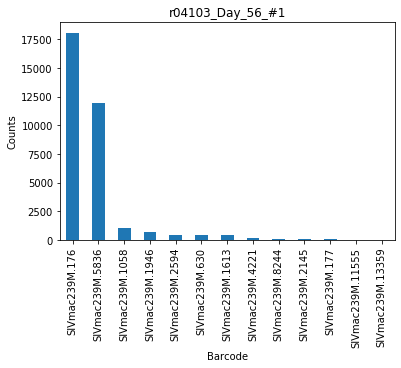

REVISED_STATS_trimmed_r10001_Day_28_#2.fastq.gz_Barcode Analysis_Cutoff.csv


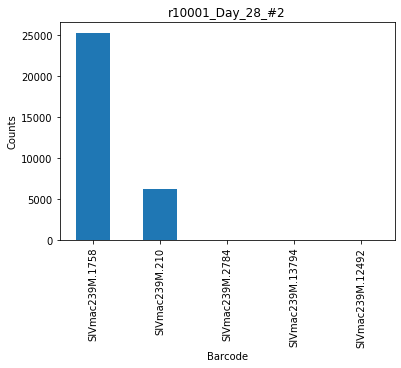

REVISED_STATS_trimmed_r10001_Day_07_#1.fastq.gz_Barcode Analysis_Cutoff.csv


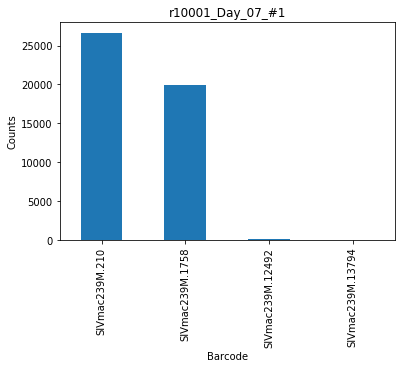

REVISED_STATS_trimmed_r04103_Day_42_#2.fastq.gz_Barcode Analysis_Cutoff.csv


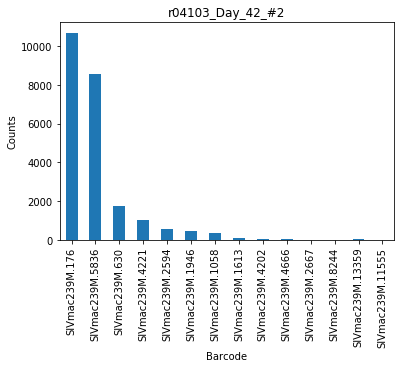

REVISED_STATS_trimmed_r10001_Day_84_#1.fastq.gz_Barcode Analysis_Cutoff.csv


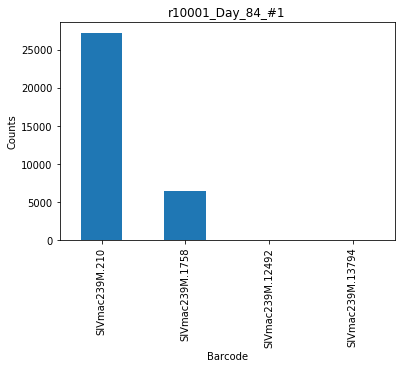

REVISED_STATS_trimmed_r04103_Day_21_#1.fastq.gz_Barcode Analysis_Cutoff.csv


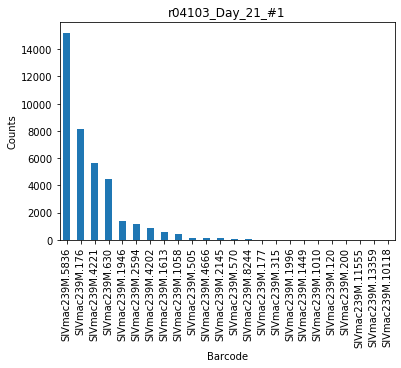

REVISED_STATS_trimmed_r04103_Day_14_#1.fastq.gz_Barcode Analysis_Cutoff.csv


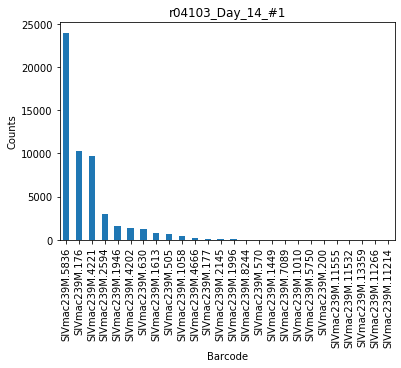

REVISED_STATS_trimmed_r10001_Day_70_#1.fastq.gz_Barcode Analysis_Cutoff.csv


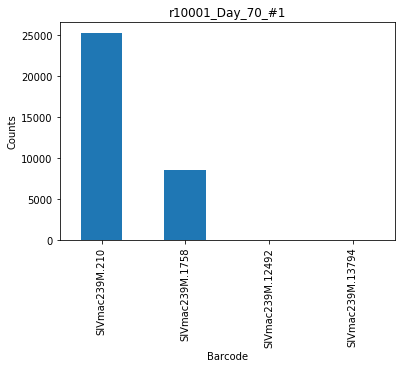

REVISED_STATS_trimmed_r10001_Inoculum-R1-24162.fastq.gz_Barcode Analysis_Cutoff.csv


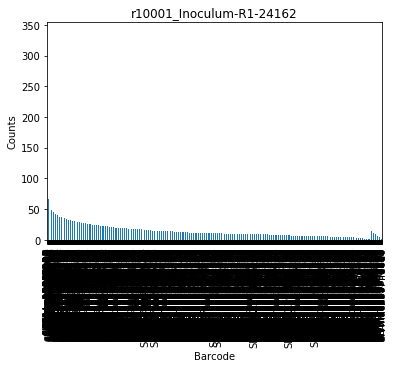

REVISED_STATS_trimmed_r04103_Inoculum-R2-24179.fastq.gz_Barcode Analysis_Cutoff.csv


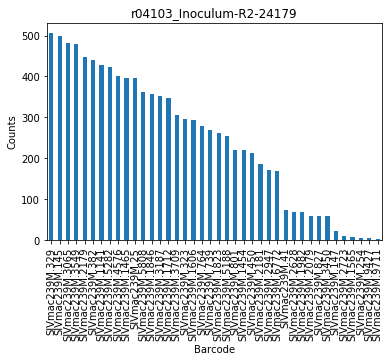

REVISED_STATS_trimmed_r10001_Day_14_#2.fastq.gz_Barcode Analysis_Cutoff.csv


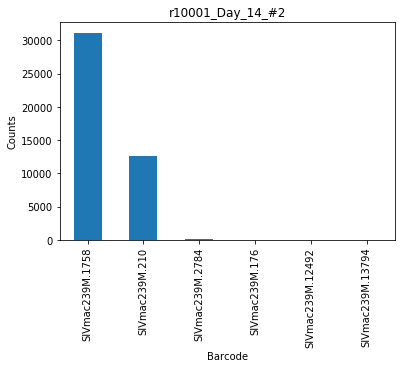

REVISED_STATS_trimmed_r04103_Day_70_#2.fastq.gz_Barcode Analysis_Cutoff.csv


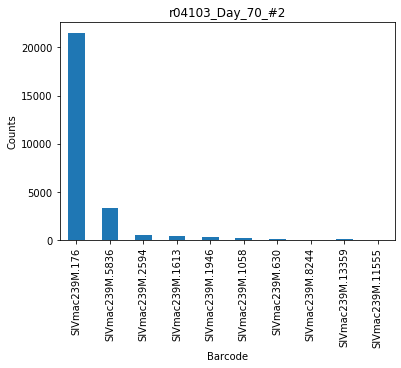

REVISED_STATS_trimmed_r04103_Day_84_#2.fastq.gz_Barcode Analysis_Cutoff.csv


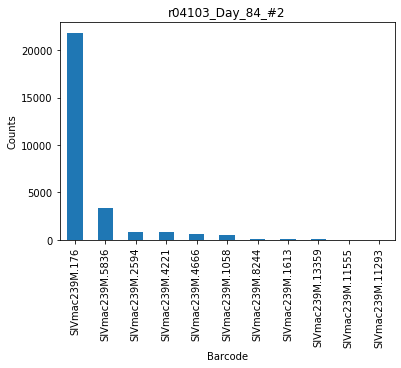

REVISED_STATS_trimmed_r04103_Day_28_#1.fastq.gz_Barcode Analysis_Cutoff.csv


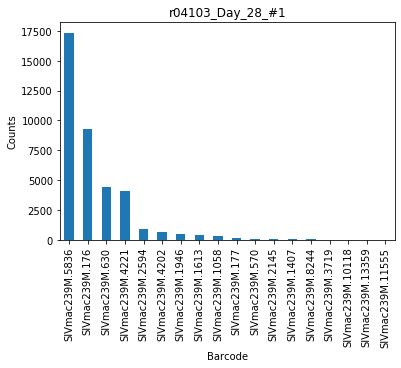

REVISED_STATS_trimmed_r10001_Day_56_#2.fastq.gz_Barcode Analysis_Cutoff.csv


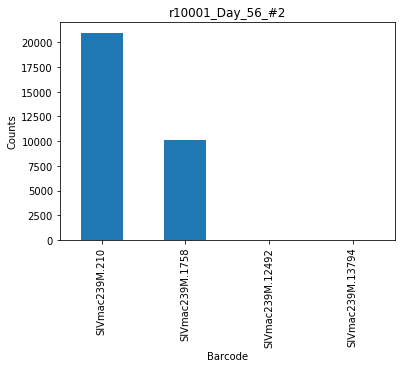

REVISED_STATS_trimmed_r10001_Day_42_#1.fastq.gz_Barcode Analysis_Cutoff.csv


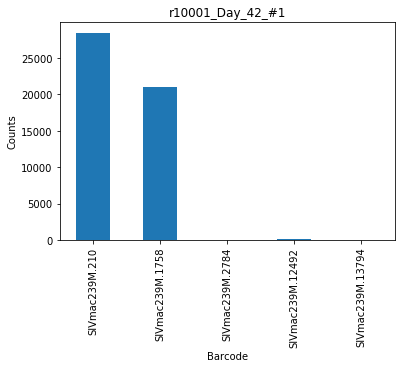

REVISED_STATS_trimmed_r04103_Day_07_#2.fastq.gz_Barcode Analysis_Cutoff.csv


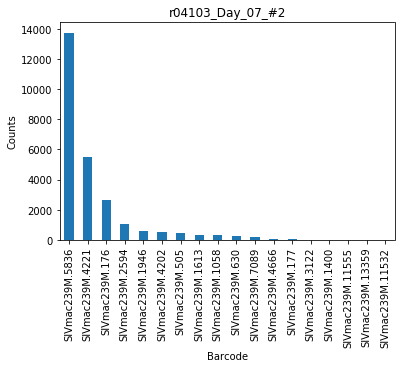

REVISED_STATS_trimmed_r04103_Day_70_#1.fastq.gz_Barcode Analysis_Cutoff.csv


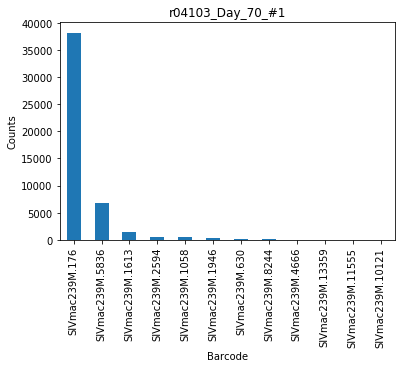

REVISED_STATS_trimmed_r10001_Day_14_#1.fastq.gz_Barcode Analysis_Cutoff.csv


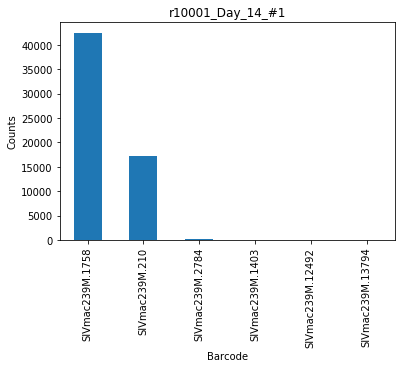

REVISED_STATS_trimmed_r10001_Day_21_#1.fastq.gz_Barcode Analysis_Cutoff.csv


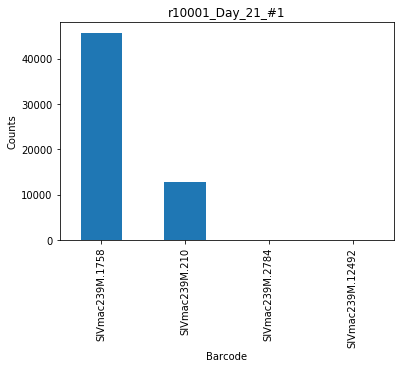

REVISED_STATS_trimmed_r04103_Day_84_#1.fastq.gz_Barcode Analysis_Cutoff.csv


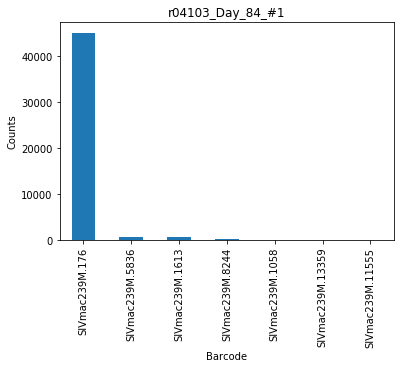

REVISED_STATS_trimmed_r04103_Day_07_#1.fastq.gz_Barcode Analysis_Cutoff.csv


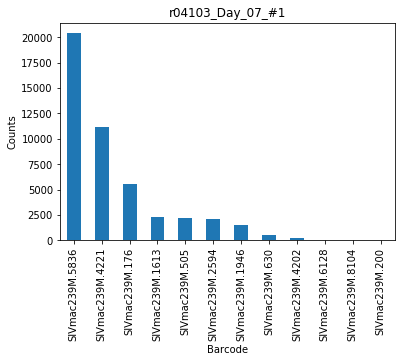

REVISED_STATS_trimmed_r10001_Day_42_#2.fastq.gz_Barcode Analysis_Cutoff.csv


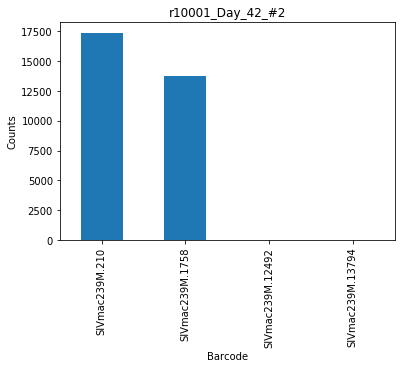

REVISED_STATS_trimmed_r10001_Day_56_#1.fastq.gz_Barcode Analysis_Cutoff.csv


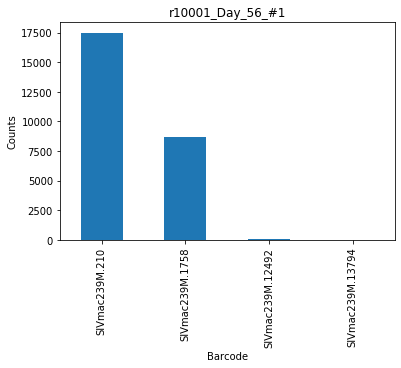

REVISED_STATS_trimmed_r04103_Day_28_#2.fastq.gz_Barcode Analysis_Cutoff.csv


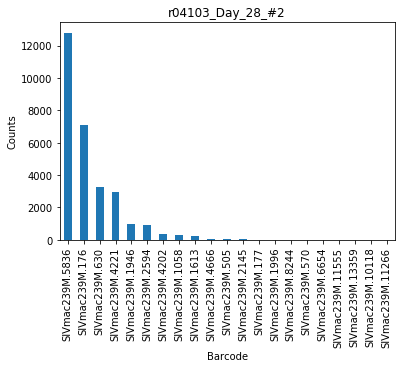

REVISED_STATS_trimmed_r04103_Day_42_#1.fastq.gz_Barcode Analysis_Cutoff.csv


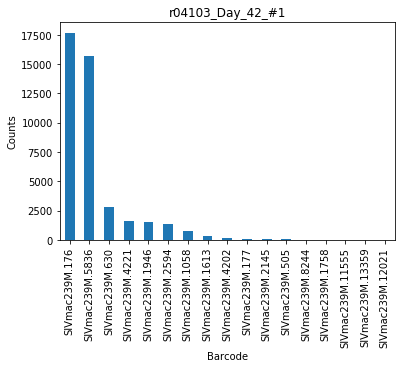

REVISED_STATS_trimmed_r10001_Day_07_#2.fastq.gz_Barcode Analysis_Cutoff.csv


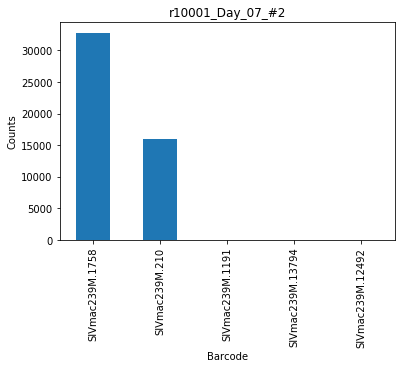

REVISED_STATS_trimmed_r10001_Day_28_#1.fastq.gz_Barcode Analysis_Cutoff.csv


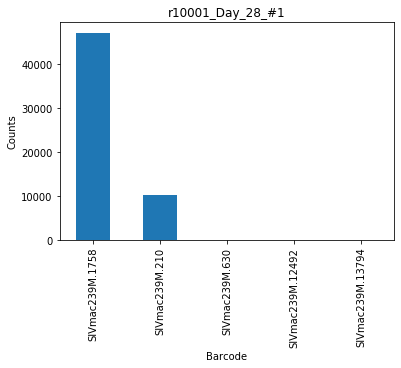

REVISED_STATS_trimmed_r04103_Day_56_#2.fastq.gz_Barcode Analysis_Cutoff.csv


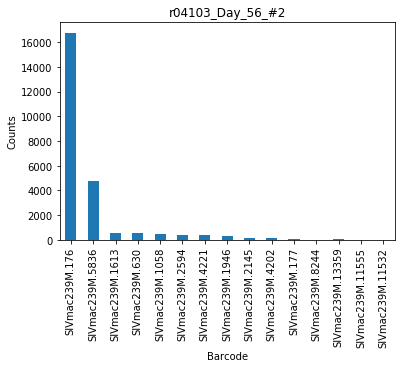

REVISED_STATS_trimmed_r10001_Day_84_#2.fastq.gz_Barcode Analysis_Cutoff.csv


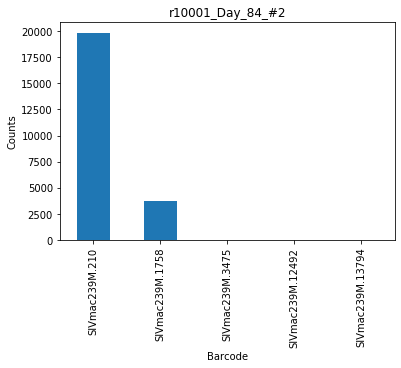

REVISED_STATS_trimmed_r10001_Day_70_#2.fastq.gz_Barcode Analysis_Cutoff.csv


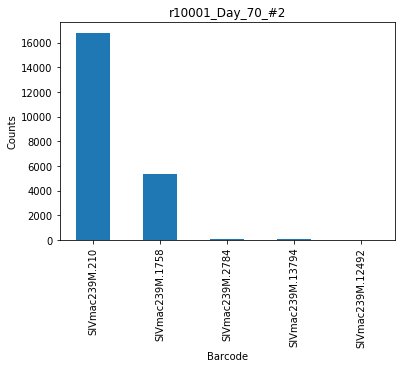

REVISED_STATS_trimmed_r04103_Day_21_#2.fastq.gz_Barcode Analysis_Cutoff.csv


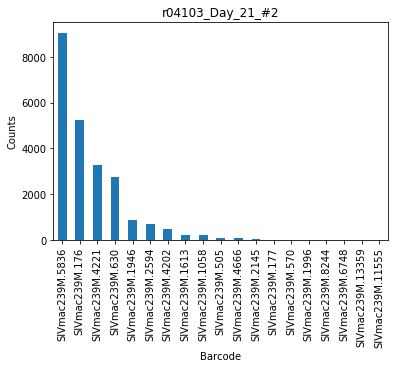

REVISED_STATS_trimmed_r04103_Day_14_#2.fastq.gz_Barcode Analysis_Cutoff.csv


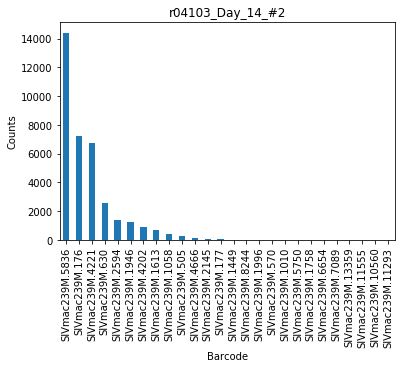

In [221]:
#present the setting with copy warning by disabling chained assignment
pd.options.mode.chained_assignment = None

#this function is going to create a plot of each of the variant quantities
def plotting_variant_quantities():
    for f in os.listdir(splittingBarcodeAnalysisOutputDirectory):
        if fnmatch.fnmatch(f, "REVISED_STATS*.csv"):
            print(f)
            #this uses the barcode name and count columns of the csv file (columns 1 and 3)
            namedf = pd.read_csv(os.path.join(splittingBarcodeAnalysisOutputDirectory,f), usecols=[0,2])
            #filters out unique barcodes and only keeps the SIV barcodes
            df = namedf[namedf["Barcode"].str.contains("SIV", na=False)]
            f1 = f.split(".")
            f2 = f1[0]
            f3 = f2.split("trimmed_")
            #revises the title of the graph to only include pertinent information
            f4 = f3[1]
            #creates a bar plot with Barcode on the x axis and counts on the y axis
            df.plot(kind='bar', x='Barcode', y='Counts', title=f4, legend=False) 
            plt.ylabel("Counts")
            plt.show()

plot_variant_quantities=plotting_variant_quantities()

       

# Revised Stats Spreadsheet Manipulation

This step will first move all of the revised stats files into the step 6 summary spreadsheet directory. From there, we use the file names from each of the revised stats files (edited so we are only using a portion of the original name) to create directories named after each of the files. Then, after it creates a directory named after each of the files, it moves the file into the folder of the matching name. This is so that each file has it's own directory to manage all of the summary sheets that are created in the next step. 

In [222]:
#moving these files to a new folder 
def relocate_revised_stats():
    source = splittingBarcodeAnalysisOutputDirectory
    dest1 = summarySpreadsheetDirectory
    files = os.listdir(source)
    for f in files: 
        if f.startswith("REVISED_STATS"):
            full_file_name = os.path.join(source, f)
            if (os.path.isfile(full_file_name)):
                shutil.copy(full_file_name, dest1)

#makes a list of all directories so we can use this to make directories 
def make_directories_list():
    for root, dirs, files in os.walk(summarySpreadsheetDirectory):
        for filename in files:
            if filename.endswith('.csv'): #this will be where we store the names of our files
                f = re.split('_', filename)
                f1 = f[3:7] #these only keep the part of the name that you need and omits the other parts of the name
                f2 = ' '.join(f1)
                f3 = str(f2)
                f4 = f3[:-9]
                if not os.path.exists(summarySpreadsheetDirectory + "/" + f4):
                    os.makedirs(summarySpreadsheetDirectory + "/" + f4) #MAKES DIRECTORY FOR THE FILE
                shutil.move(summarySpreadsheetDirectory + "/" + filename, summarySpreadsheetDirectory + "/" + f4) #MOVES THE NAME MATCHED FILE INTO ITS CORRESPONDING DIRECTORY 

relocating_revised_stats = relocate_revised_stats()
making_directories_list = make_directories_list()

# Creating Summary Spreadsheets 1-3

This is the part of the code that will take the split and relocated files from the barcode virus analysis tool and will turn them into 3 separate spreadsheets that we will use as part of the rest of this analysis. 

In [6]:
#prevent the setting with copy warning by disabling chained assignment
pd.options.mode.chained_assignment = None

def identify_barcodes(f2):
    
    #creates an empty pandas dataframe to read the results to
    df = pd.DataFrame([])
    
    #looks only for files that start with REVISED_STATS and ends with csv
    for counter, file in enumerate(glob.glob("REVISED_STATS*.csv")):
        
        #this only uses the first and third columns of the csv file, sets the index column as the barcode name
        namedf = pd.read_csv(file, usecols=[0,2])
        df = df.append(namedf)
        
        if file.endswith('.csv'): #this will be where we store the names of our files
            f = file[22:]
            f1 = f[:-37] #these only keep the part of the name that you need and omits the other parts of the name
            f2 = str(f1)
        
    #filters out unique barcodes and only keeps the SIV barcodes
    df1 = df[df["Barcode"].str.contains("SIV", na=False)]
    
    #here we sum up the total barcode count
    total_count = df1["Counts"].sum()
    
    #here we add the column with the total barcode count
    df1["Total_Barcode_Count"] = total_count
    
    #here we create the frequency column
    df1['Percent_Composition'] = df1['Counts']/df1['Total_Barcode_Count']
    
    #creates a data frame with the raw counts of all the barcodes found in at least 0.1% proportion
    df2 = df1[["Barcode", "Counts"]]
    
    #prints the filtered barcode count data to a csv
    df2.to_csv("1_" + str(f2) + "_Filtered_Barcode_Counts.csv", index=False)
    
    #read in the source file to a pandas dataframe
    fname = "1_" + str(f2) + "_Filtered_Barcode_Counts.csv"
    df = pd.read_csv(fname)
    
    #here we sum up the total barcode count
    total_count = df["Counts"].sum()
    
    #here we add the column with the total barcode count
    df["Total_Barcode_Count"] = total_count
    
    #here we create the frequency column
    df['Percent_Composition'] = df['Counts']/df['Total_Barcode_Count']
    
    #making a new column that includes the path name 
    idx = 0
    new_col = path
    df.insert(loc=idx, column="Sample_Name", value=new_col)
    
    #making a dataframe that only has proportion so we are able to plot this
    df1 = df[["Barcode","Percent_Composition"]]
    
    #printing the dataframes to their own spreadsheets
    df.to_csv("2_" + path + "_Filtered_Barcode_Counts_and_Percentage.csv", index=False)
    df1.to_csv("3_" + path + "_Filtered_Barcode_Percentage.csv", index=False)
    
#executing workflow
#this automates the running of the code by iterating through the directories
os.chdir(summarySpreadsheetDirectory)
for i in os.listdir(summarySpreadsheetDirectory):
    
    #ignores hidden directory .DS_Store
    if i == ".DS_Store":
        continue
        
    print(i)
    
    #changes directory to the next one in the list
    os.chdir(i)
    
    #changes the path variable to the directory you just moved into
    path = i
    
    #print an update statement
    print("Starting analysis for the " + path + " directory")
    
    #execution of the functions
    listing_barcodes = identify_barcodes(making_directories_list)
    
    #printing a update statement
    print("Finished analysis for the " + path + " directory\n\n")
    
    #moves the directory back up to the original directory
    os.chdir("../")
    
os.chdir(appRoot + "/Scripts")

cy0575 Day 70
Starting analysis for the cy0575 Day 70 directory


NameError: name 'making_directories_list' is not defined

# SIMPSON'S DIVERSITY INDEX

# Simpson's Diversity Index Calculation 

In [4]:
############DEFINING THE FUNCTION#####################################################################################

def SDI(): 
    
###########NOW OPENING THE FIRST FILE TO EXTRACT THE BARCODES AND ADD THEM TO THE TOTAL POOL##########################    
    
    SDI_file_names = []
    
    SDImedians = []
    
    for roots, dirs, files in os.walk(summarySpreadsheetDirectory): 
            
        for dir in dirs: 
            
            all_barcodes1 = []
        
            #splitting the path name so we can make a list of all the samples as we iterate through the files
            split_i = re.split('/', summarySpreadsheetDirectory + "/" + dir)
            sampleName = split_i[-1]

            #adding the file name to the list of filenames to use later for an index column and row
            SDI_file_names.append(sampleName)

            #creates a list of all of the files in this directory
            directory = os.listdir(summarySpreadsheetDirectory + "/" + dir)

            #filtering the list for only the second spreadsheet, which is the only one we will be using
            first_file = [s for s in directory if s.startswith("1_")]

            #converting the file name to a string
            string_first_file = ''.join(first_file)
            
            path = str(summarySpreadsheetDirectory + "/" + dir)

            #gives us the absolute full path to the first spreadsheet in that directory
            string_path_1 = os.path.join(path, string_first_file)

            #converts this file to a pandas dataframe
            df1 = pd.read_csv(string_path_1, header=[0])
            
            #iterates through rows of the pandas dataframe
            for index, row in df1.iterrows(): 

                #creates a "counts" value that gives the number of times that this barcode is found in that file
                counts1 = row['Counts']
                counts1 = int(counts1)

                #gives us the name of the barcode associated with the count right above
                barcode1 = row['Barcode']

                #this appends all the barcode names to the list in the range that is given in the counts column
                all_barcodes1.extend([barcode1 for x in range(counts1)])

            #convert all_barcodes to a numpy array 
            array1 = np.array(all_barcodes1)

###########NOW SETTING THE LOOP THAT WILL RUN THIS PIPELINE IN REPLICATE##############################################
            
            #this is going to create a list of all SDI values creates during this step so we can find the median
            #value and make that the final value 
            SDIreplicates = []
        
            #this is going to run the "picking" from the all_barcodes array a fixed number of times ("replicates" value)
            for x in range(0, replicates):
        
##########NOW RANDOMLY SELECTING OUR SET OF READS FROM BOTH FILES AND USES IT TO RUN SDI###############################     
    
                #numpy will randomly select 2000 elements from the first array
                #subsample1 = np.random.choice(array1, 2000, replace=False)

                #splits the first list back up into the barcode name and subsequent counts
                #uniques1, counts1 = np.unique(subsample1, return_counts=True)

                #zips the unique barcode identity to its subsequent count value in a dictionary
                #subsampleCounts1 = dict(zip(uniques1, counts1))

                #converts this dictionary to a pandas dataframe 
                #f1 = pd.DataFrame(subsampleCounts1.items(), columns=['Barcode', 'Counts'])
                
###########NOW RUNNING SDI CALCULATION ON THIS DATAFRAME##############################################################
                
                #this only uses the counts column 
                #f2 = f1['Counts']
                f2 = df1['Counts']
                
                #this turns the column into a numpy array to convert them into integers
                a = np.array(f2)
                
                #sums the counts column (should match the number of reads we pulled out)
                N = df1['Counts'].sum()
                
                #creates a list to turn into the number for the numerator
                numerator = 0
                
                #creates the sum to be used in the numerator
                for i in a: 
                    numerator = numerator + i*(i-1)
                
                #this actually calculates the Simpson diversity index
                SDI = float(1-(numerator/(N*(N-1))))
                
                #this appends the SDI value to the list
                SDIreplicates.append(SDI)
            
            #this finds the median value from the list of replicates 
            SDImedian = statistics.median(SDIreplicates)
            
            #adding this value to the list of SDI medians
            SDImedians.append(SDImedian)
            
            #sets the new file name equal to a variable so it can be created later 
            fname = sdiDirectory + "/" + 'Simpson_Diversity_Index_allreads_' + str(replicates) + "replicates.csv"
            
    #zips the SDI file names to the corresponding median values to use to make a spreadsheet
    SDI_values = dict(zip(SDI_file_names, SDImedians))

    #converts this first dictionary to a pandas dataframe so we can save it as a csv file
    SDI_df = pd.DataFrame(SDI_values.items(), columns=['Time_Point', 'SDI_Value'])
    
    #save this dataframe to a csv 
    SDI_df.to_csv(fname, columns=['Time_Point', 'SDI_Value'])
    
    #creating a dataframe that only contains information from the first animal
    df1 = SDI_df[SDI_df['Time_Point'].str.contains(animal1name)]
    
    #creating a dataframe that only contains information from the second animal
    df2 = SDI_df[SDI_df['Time_Point'].str.contains(animal2name)]
    
    #sorts the data from animal 1 by time point 
    df3= df1.sort_values(by=['Time_Point'])
    
    #filters the dataframe so we no longer have the animal name in the title
    df3["Time_Point"] = df3['Time_Point'].str.split(pat=' ').str[1:4]
    df3['Time_Point'] = df3['Time_Point'].str.join(' ')
    
    #sorts the data from animal 2 by time point
    df4=df2.sort_values(by=['Time_Point'])
    
    #filters the dataframe so we no longer have the animal name in the title
    df4['Time_Point'] = df4['Time_Point'].str.split(pat=' ').str[1:4]
    df4['Time_Point'] = df4["Time_Point"].str.join(' ')
    
    df3.to_csv(sdiFinalSpreadsheets + "/" + "SDI_allreads_" + str(replicates) + "reps_" + animal1name + ".csv", index=False)
    df4.to_csv(sdiFinalSpreadsheets + "/" + "SDI_allreads_" + str(replicates) + "reps_" + animal2name + ".csv", index=False)
    
    
Simpsons = SDI()

# Plotting Simpson's Diversity Index Values

In this portion of the code, we are going to take the manipulated/beautified spreadsheets from the kernel above and we will use them to plot the SDI values. 

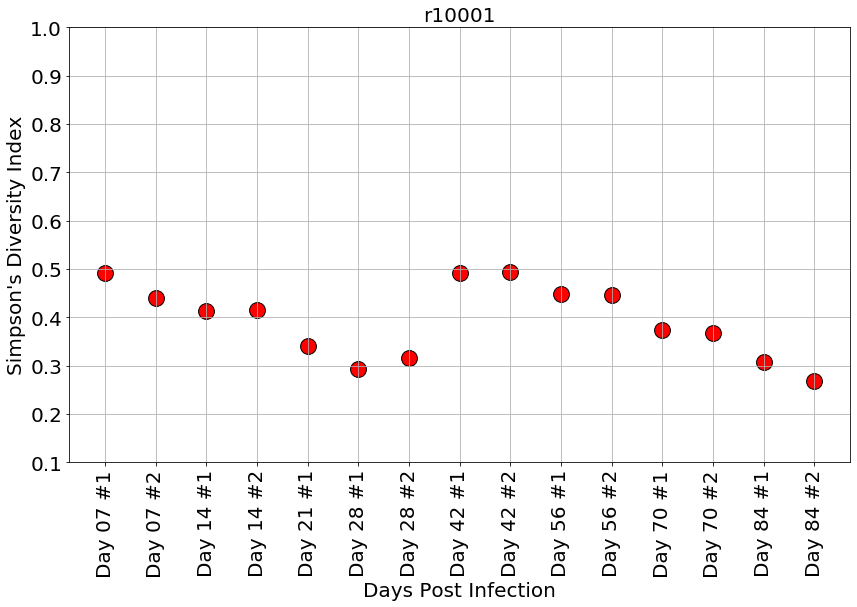

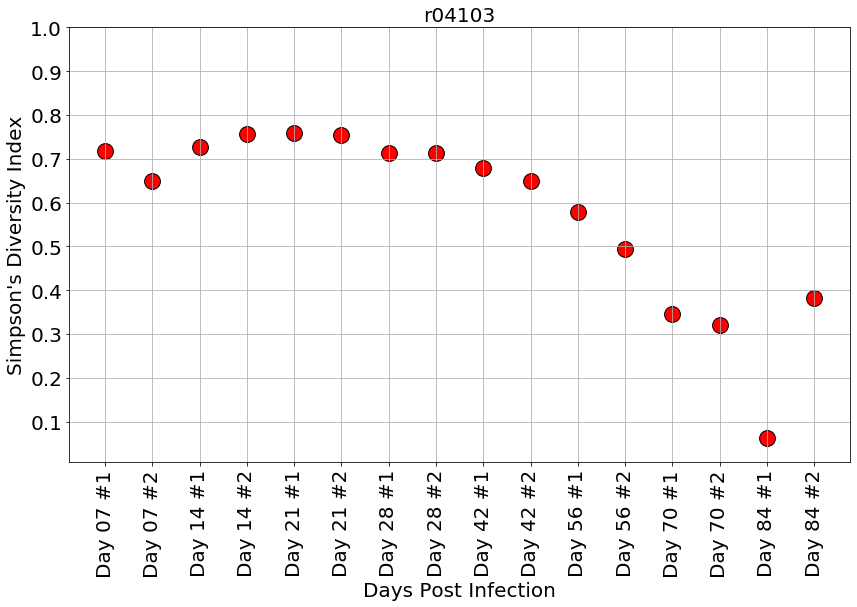

In [309]:
def plotting_SDI():
    
    #importing SDI spreadsheet from animal 1 as a dataframe
    df1 = pd.read_csv(sdiFinalSpreadsheets + "/" + "SDI_2000reads_" + str(replicates) + "reps_" + animal1name + ".csv")
    #creating and setting parameters for the scatter plot for the first dataframe
    fig, ax = plt.subplots()
    
    #changes the size of the figure to make it much larger than default
    fig.set_size_inches(14,8)
    
    #actually plots the data with time point on the x axis, SDI on the y axis, color blue, larger than normal dots, 
    #and an edge color of black for each of the dots as well 
    plt.scatter(df1.Time_Point, df1.SDI_Value, c=color, s=250, edgecolors = 'k')
    
    #changes the value and font size of the x label
    plt.xlabel("Days Post Infection", fontsize=20)
    
    #changes the value and font size of the y label
    plt.ylabel("Simpson's Diversity Index", fontsize=20)
    
    #increases size of the x ticks and rotates them 90 degrees 
    plt.xticks(fontsize=20, rotation=90)
    
    #increases the size of the y ticks and defines which exact ticks we want on the axis, otherwise it will infer
    plt.yticks(fontsize=20, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    
    #adds a title to the graph and edits the size of the title
    plt.title(animal1name, fontsize = 20)
    
    #adds major gridlines to the graph
    plt.grid(which='major')
    
    #adds minor gridlines to the graph
    #ax.minorticks_on()
    
    #makes the minor gridlines a more of a ticked style rather than solid lines
    #ax.grid(which='minor', linestyle=':')
    
    #shows the plot in line
    plt.show()

    #importing the data frame animal 2 as a dataframe
    df2 = pd.read_csv(sdiFinalSpreadsheets + "/" + "SDI_2000reads_" + str(replicates) + "reps_" + animal2name + ".csv")
    
    #creating and setting parameters for the scatter plot for the second dataframe
    fig, ax = plt.subplots()
    
    #changes the size of the plot to be much larger than default
    fig.set_size_inches(14,8)
    
    #actually plots the data with time point on the x axis, SDI on the y axis, color blue, larger than normal dots, 
    #and an edge color of black for each of the dots as well to make them more visible. 
    plt.scatter(df2.Time_Point, df2.SDI_Value, c=color, s=250, edgecolors = 'k')
    
    #changes the value and font size of the x label
    plt.xlabel("Days Post Infection", fontsize=20)
    
    #changes the value and font size of the y label
    plt.ylabel("Simpson's Diversity Index", fontsize=20)
    
    #increases the size of the x ticks and rotates them 90 degrees
    plt.xticks(fontsize=20, rotation=90)
    
    #increases the size of the y ticks and defines which exact ticks we want on the axis, otherwise it will infer
    plt.yticks(fontsize=20, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    
    #adds a title to the graph and edits the size of the title
    plt.title(animal2name, fontsize = 20)
    
    #adds major gridlines to the graph
    plt.grid(which='major')
    
    #adds minor gridlines to the graph
    #ax.minorticks_on()
    
    #edits the minor gridlines so that they have more of a ticked style rather than solid lines
    #ax.grid(which='minor', linestyle=':')
    
    #shows the plot in line
    plt.show()
    
plot_SDI = plotting_SDI()

# REFERENCE AND EXPERIMENTAL MORISITA-HORN

# Reference Permutations --> Reference Morisita-Horn Calculation Animal 1

This kernel is going to look at every single combination of files. With each combination of 2 files, it is going to pool all of the barcodes from the two original files, and then it's going to pull out 2000 reads to make our two "reference" files. These will stand in place of the two original files, as a "reference" distribution. This way, when we are doing our Morisita-Horn and Simpson's Diversity Index calculations, we will be able to see how these "experimental" distributions that are pulled from only their original file compare to those that were pooled with both and pulled from there. If there is a huge difference between the average Morisita-Horn value in the experimental groups and in the reference groups, it is very possible that you have a distribution that is different than would be expected with just an average draw from those two samples. 

In [350]:
############NOW CREATING AN EMPTY NUMPY ARRAY TO BE USED LATER TO APPEND OUR VALUES TO################################ 

reference1_array = np.zeros(shape=(numsamples_animal1,numsamples_animal1))

############DEFINING THE FUNCTION#####################################################################################

def reference_permutation1():
    
###########NOW OPENING THE FIRST FILE TO EXTRACT THE BARCODES AND ADD THEM TO THE TOTAL POOL##########################    
    
    #creating counters for loop 1 and loop 2 so that we can use them to plug in the values to the empty numpy array
    counter1 = 0
    
    #make a list of all of the file names so we can use it for an index column and row later on
    reference1_file_names = []
    
    for i in animal_1_folders: 
        
        all_barcodes = []
        
        #adding 1 to the first counter
        counter1 = counter1 + 1
        
        #splitting the path name so we can make a list of all the samples as we iterate through the files
        split_i = re.split('/', i)
        sampleName = split_i[-1]

        #adding the file name to the list of filenames to use later for an index column and row
        reference1_file_names.append(sampleName)
        print("The file_names list is: ")
        print(reference1_file_names)

        #resetting counter two when we open a new first file so it only goes up to the value it needs to be at
        counter2 = 0

        #creates a list of all of the files in this directory
        directory = os.listdir(i)
        
        #filtering the list for only the second spreadsheet, which is the only one we will be using
        first_file = [s for s in directory if s.startswith("1_")]
        
        #converting the file name to a string
        string_first_file = ''.join(first_file)
        
        #gives us the absolute full path to the first spreadsheet in that directory
        string_path_1 = os.path.join(i, string_first_file)

        #converts this file to a pandas dataframe
        df1 = pd.read_csv(string_path_1, header=[0])

        
############NOW OPENING THE SECOND FILE TO EXTRACT THE BARCODES AND ADD THEM TO THE TOTAL POOL########################            

        #we are moving through the directory for the second time now...
        for i in animal_1_folders: 
            
            #resets the all_barcodes list so we don't have old data hanging out in it
            all_barcodes = []
            
            #creates a list of all the files in this directory
            directory = os.listdir(i)
            
            #filtering the list for only the second spreadsheet, which is the only one we will be using
            first_file2 = [s for s in directory if s.startswith("1_")]
            
            #converting the file name to a string
            string_first_file2 = ''.join(first_file2)
            
            #adding 1 to counter 2
            counter2 = counter2 + 1
            
            #gives us the absolute full path to the first spreadsheet in that directory (i)
            string_path_2 = os.path.join(i, string_first_file2)
            print("The first path is: " + string_path_1)
            print("The second path is: " + string_path_2)
            
            #converts string_path_2 to a pandas dataframe
            df2 = pd.read_csv(string_path_2, header=[0])

###########NOW DEFINING THE LIST AND APPENDING ALL OF THE BARCODES TO THE LIST AS WELL################################
    
            #creates an empty list for the barcodes to be stored in
            all_barcodes = []
            
            #iterates through rows of the first pandas dataframe
            for index, row in df1.iterrows(): 

                #creates a "counts" value that gives the number of times that this barcode is found in that file
                counts1 = row['Counts']
                counts1 = int(counts1)

                #gives us the name of the barcode associated with the count right above
                barcode1 = row['Barcode']

                #this appends all the barcode names to the list in the range that is given in the counts column
                all_barcodes.extend([barcode1 for x in range(counts1)])
            
            #iterates through rows of the pandas dataframe
            for index, row in df2.iterrows(): 

                #creates a "counts" value that gives the number of times that this barcode is found in that file
                counts2 = row['Counts']
                counts2 = int(counts2)

                #gives us the name of the barcode associated with the count right above
                barcode2 = row['Barcode']

                #this appends all the barcode names to the list in the range that is given in the counts column
                all_barcodes.extend([barcode2 for x in range(counts2)])
                
            #convert all_barcodes to a numpy array 
            array2 = np.array(all_barcodes)
            
            print("Counter 1 equals: ") 
            print(counter1)

            print("Counter 2 equals: ")
            print(counter2)

###########NOW SETTING THE LOOP THAT WILL RUN THIS PIPELINE IN REPLICATE##############################################
            
            #this is going to create a list of all M-H values creates during this step so we can find the median
            #value and append that to the Morisita-Horn array 
            MHreplicates = []
        
            #this is going to run the "picking" from the all_barcodes array a fixed number of times ("replicates" value)
            for x in range(0, replicates):
                
###########NOW SPLITTING THE POOL UP INTO 2 POOLS OF 2000 READS AND PREPARING THEM FOR MORISITA-HORN##################

                #numpy will randomly select 2000 elements from the array, which makes a 2,000 count subset of the original
                subsample1 = np.random.choice(array2, 2000, replace=False)

                #numpy will once again randomly select 2000 elements from the array, so we have a second reference frame
                subsample2 = np.random.choice(array2, 2000, replace=False)

                #splits the first list back up into the barcode name and subsequent counts
                uniques1, counts1 = np.unique(subsample1, return_counts=True)

                #splits the second list back up into the barcode name and subsequent counts
                uniques2, counts2 = np.unique(subsample2, return_counts=True)

                #zips the unique barcode identity to its subsequent count value in a dictionary for the first pool
                subsampleCounts1 = dict(zip(uniques1, counts1))

                #zips the unique barcode identity to its subsequent count value in a dictionary for the second pool 
                subsampleCounts2 = dict(zip(uniques2, counts2))

                #converts this first dictionary to a pandas dataframe so we can use it for Morisita-Horn computation
                f1 = pd.DataFrame(subsampleCounts1.items(), columns=['Barcode', 'Counts'])

                #converts this second dictionary to a pandas dataframe so we can use it for Morisita-Horn computation
                f2 = pd.DataFrame(subsampleCounts2.items(), columns=['Barcode', 'Counts'])

####NOW CALCULATING MORISITA-HORN VALUES###########################################################################            

                #explicitly state the total counts (2000 due to permutation) for the large X value for the denominator
                X = 2000

                #convert the file to numpy for some of the later analysis
                file1 = f1.to_numpy()

                #explicitly state the total counts (2000 due to permutation) for the large Y value for the denominator
                Y = 2000

                #convert the second file to numpy for some of the later analysis
                file2 = f2.to_numpy()

                #merges the barcode lists from both of the original files so you can see them all in one list
                f1_f2 = pd.concat([f1, f2], ignore_index=True)

                #makes a list of all barcodes found in these two files
                barcodes = f1_f2["Barcode"].values

                #edits the list to all unique barcodes found in the two files 
                uniqueBarcodes = np.unique(barcodes)
                uniqueBarcodes.astype('|S16')

                #defining variables for later
                numerator = 0
                xSquared = 0
                ySquared = 0

                for f in uniqueBarcodes: 

                    #determining x and y values for the equation
                    x = 0
                    y = 0

                    #makes a first dataframe that has all string matches
                    matchRow1 = f1[f1['Barcode'].str.match(f)]

                    #since there might be multiple string matches, we need to filter for just the one we want
                    final1 = matchRow1[matchRow1['Barcode'] == f]

                    #if there is no barcode at all, you want to set that x value equal to zero
                    if final1.empty == True: 
                        x = 0
                    #otherwise, we want to set x equal to the counts
                    else:
                        x = final1['Counts'].values[0]

                    #this does the same thing with the second file
                    matchRow2 = f2[f2['Barcode'].str.match(f)]

                    #this once again makes a dataframe with all matches
                    final2 = matchRow2[matchRow2['Barcode'] == f]

                    #if there is no barcode, set the y value equal to zero
                    if final2.empty == True:
                        y = 0
                    else:
                        y = final2['Counts'].values[0]

                    #calculating the numerator (multiplying by 2 happens at the very end)
                    numerator = numerator + (x * y)  

                    #calculating the first part of the denominator (dividing comes later)
                    xSquared = xSquared + (x ** 2)

                    #calculating the first part of the denominator (dividing comes later)
                    ySquared = ySquared + (y ** 2)

                #FINAL CALCULATIONS FOR THIS PAIR OF FILES

                #multiplying the numerator sum by 2 to get the final numerator 
                numerator = numerator * 2

                #dividing the xSquared sum by X**2
                denomX = xSquared / (X ** 2)

                #dividing the ySquared sum by Y**2 
                denomY = ySquared / (Y ** 2)

                #adding the denomX and denomY values
                denomXplusY = denomX + denomY

                #final denominator value
                denominator = denomXplusY * (X*Y)

                #final MH value
                MH = numerator / denominator
                
                #printing the list of all the Morisita-Horn values for this pair of files
                MHreplicates.append(MH)
            
            #finds the median value from this list
            MHmedian = statistics.median(MHreplicates)

            #adds the MH value to the current counter value's location in the empty numpy array
            reference1_array[counter1-1, counter2-1] = MH
    print(reference1_array)
    return reference1_array, reference1_file_names
    


reference1_array, reference1_file_names = reference_permutation1()

The file_names list is: 
['cy0428 Day 84 #1']
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 84 #1/1_cy0428_Day_84_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 84 #1/1_cy0428_Day_84_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
1
Counter 2 equals: 
1
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 84 #1/1_cy0428_Day_84_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 17 #1/1_cy0428_Day_17_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
1
Counter 2 equals: 
2
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 84 #1/1_cy0428_Day_84_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 10 #1/1_cy0428_Day_10_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
1
Counter 2 equals: 
20
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 84 #1/1_cy0428_Day_84_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 28 #2/1_cy0428_Day_28_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
1
Counter 2 equals: 
21
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 17 #1/1_cy0428_Day_17_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 17 #2/1_cy0428_Day_17_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
2
Counter 2 equals: 
16
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 17 #1/1_cy0428_Day_17_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 42 #2/1_cy0428_Day_42_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
2
Counter 2 equals: 
17
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6

Counter 1 equals: 
3
Counter 2 equals: 
11
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 07 #1/1_cy0428_Day_07_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 21 #2/1_cy0428_Day_21_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
3
Counter 2 equals: 
12
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 07 #1/1_cy0428_Day_07_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 84 #2/1_cy0428_Day_84_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
3
Counter 2 equals: 
13
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_

Counter 1 equals: 
4
Counter 2 equals: 
7
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 56 #1/1_cy0428_Day_56_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 28 #1/1_cy0428_Day_28_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
4
Counter 2 equals: 
8
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 56 #1/1_cy0428_Day_56_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 10 #2/1_cy0428_Day_10_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
4
Counter 2 equals: 
9
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI

Counter 1 equals: 
5
Counter 2 equals: 
3
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 42 #1/1_cy0428_Day_42_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 56 #1/1_cy0428_Day_56_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
5
Counter 2 equals: 
4
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 42 #1/1_cy0428_Day_42_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 42 #1/1_cy0428_Day_42_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
5
Counter 2 equals: 
5
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 42 #1/1_cy0428_Day_42_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 21 #1/1_cy0428_Day_21_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
5
Counter 2 equals: 
23
The file_names list is: 
['cy0428 Day 84 #1', 'cy0428 Day 17 #1', 'cy0428 Day 07 #1', 'cy0428 Day 56 #1', 'cy0428 Day 42 #1', 'cy0428 Day 03 #1']
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 03 #1/1_cy0428_Day_03_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 84 #1/1_cy0428_Day_84_#1_Filtered_Barcode_Counts.csv
Count

Counter 1 equals: 
6
Counter 2 equals: 
18
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 03 #1/1_cy0428_Day_03_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 24 #1/1_cy0428_Day_24_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
6
Counter 2 equals: 
19
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 03 #1/1_cy0428_Day_03_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 10 #1/1_cy0428_Day_10_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
6
Counter 2 equals: 
20
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 14 #2/1_cy0428_Day_14_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 07 #2/1_cy0428_Day_07_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
7
Counter 2 equals: 
14
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 14 #2/1_cy0428_Day_14_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 56 #2/1_cy0428_Day_56_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
7
Counter 2 equals: 
15
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 28 #1/1_cy0428_Day_28_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 10 #2/1_cy0428_Day_10_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
8
Counter 2 equals: 
9
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 28 #1/1_cy0428_Day_28_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 24 #2/1_cy0428_Day_24_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
8
Counter 2 equals: 
10
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 10 #2/1_cy0428_Day_10_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 56 #1/1_cy0428_Day_56_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
9
Counter 2 equals: 
4
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 10 #2/1_cy0428_Day_10_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 42 #1/1_cy0428_Day_42_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
9
Counter 2 equals: 
5
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.C

Counter 1 equals: 
9
Counter 2 equals: 
22
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 10 #2/1_cy0428_Day_10_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 21 #1/1_cy0428_Day_21_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
9
Counter 2 equals: 
23
The file_names list is: 
['cy0428 Day 84 #1', 'cy0428 Day 17 #1', 'cy0428 Day 07 #1', 'cy0428 Day 56 #1', 'cy0428 Day 42 #1', 'cy0428 Day 03 #1', 'cy0428 Day 14 #2', 'cy0428 Day 28 #1', 'cy0428 Day 10 #2', 'cy0428 Day 24 #2']
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 24 #2/1_cy0428_Day_24_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp49

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 24 #2/1_cy0428_Day_24_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 14 #1/1_cy0428_Day_14_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
10
Counter 2 equals: 
18
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 24 #2/1_cy0428_Day_24_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 24 #1/1_cy0428_Day_24_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
10
Counter 2 equals: 
19
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Ste

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 70 #2/1_cy0428_Day_70_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 84 #2/1_cy0428_Day_84_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
11
Counter 2 equals: 
13
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 70 #2/1_cy0428_Day_70_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 07 #2/1_cy0428_Day_07_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
11
Counter 2 equals: 
14
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Ste

Counter 1 equals: 
12
Counter 2 equals: 
7
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 21 #2/1_cy0428_Day_21_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 28 #1/1_cy0428_Day_28_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
12
Counter 2 equals: 
8
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 21 #2/1_cy0428_Day_21_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 10 #2/1_cy0428_Day_10_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
12
Counter 2 equals: 
9
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 84 #2/1_cy0428_Day_84_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 07 #1/1_cy0428_Day_07_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
13
Counter 2 equals: 
3
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 84 #2/1_cy0428_Day_84_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 56 #1/1_cy0428_Day_56_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
13
Counter 2 equals: 
4
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 84 #2/1_cy0428_Day_84_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 70 #1/1_cy0428_Day_70_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
13
Counter 2 equals: 
22
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 84 #2/1_cy0428_Day_84_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 21 #1/1_cy0428_Day_21_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
13
Counter 2 equals: 
23
The file_names list is: 
['cy0428 Day 84 #1', 'cy0428 Day 17 #1', 'cy0428 Day 07 #1', 'cy0428 Day 56 #1', 

Counter 1 equals: 
14
Counter 2 equals: 
16
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 07 #2/1_cy0428_Day_07_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 42 #2/1_cy0428_Day_42_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
14
Counter 2 equals: 
17
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 07 #2/1_cy0428_Day_07_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 14 #1/1_cy0428_Day_14_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
14
Counter 2 equals: 
18
The first path is: /Users/agolfinos/Desktop/Research_Projects/

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 56 #2/1_cy0428_Day_56_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 21 #2/1_cy0428_Day_21_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
15
Counter 2 equals: 
12
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 56 #2/1_cy0428_Day_56_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 84 #2/1_cy0428_Day_84_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
15
Counter 2 equals: 
13
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Ste

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 17 #2/1_cy0428_Day_17_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 14 #2/1_cy0428_Day_14_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
16
Counter 2 equals: 
7
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 17 #2/1_cy0428_Day_17_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 28 #1/1_cy0428_Day_28_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
16
Counter 2 equals: 
8
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 42 #2/1_cy0428_Day_42_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 17 #1/1_cy0428_Day_17_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
17
Counter 2 equals: 
2
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 42 #2/1_cy0428_Day_42_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 07 #1/1_cy0428_Day_07_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
17
Counter 2 equals: 
3
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6

Counter 1 equals: 
17
Counter 2 equals: 
20
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 42 #2/1_cy0428_Day_42_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 28 #2/1_cy0428_Day_28_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
17
Counter 2 equals: 
21
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 42 #2/1_cy0428_Day_42_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 70 #1/1_cy0428_Day_70_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
17
Counter 2 equals: 
22
The first path is: /Users/agolfinos/Desktop/Research_Projects/

Counter 1 equals: 
18
Counter 2 equals: 
15
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 14 #1/1_cy0428_Day_14_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 17 #2/1_cy0428_Day_17_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
18
Counter 2 equals: 
16
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 14 #1/1_cy0428_Day_14_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 42 #2/1_cy0428_Day_42_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
18
Counter 2 equals: 
17
The first path is: /Users/agolfinos/Desktop/Research_Projects/

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 24 #1/1_cy0428_Day_24_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 70 #2/1_cy0428_Day_70_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
19
Counter 2 equals: 
11
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 24 #1/1_cy0428_Day_24_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 21 #2/1_cy0428_Day_21_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
19
Counter 2 equals: 
12
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Ste

Counter 1 equals: 
20
Counter 2 equals: 
5
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 10 #1/1_cy0428_Day_10_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 03 #1/1_cy0428_Day_03_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
20
Counter 2 equals: 
6
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 10 #1/1_cy0428_Day_10_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 14 #2/1_cy0428_Day_14_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
20
Counter 2 equals: 
7
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 28 #2/1_cy0428_Day_28_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 17 #1/1_cy0428_Day_17_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
21
Counter 2 equals: 
2
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 28 #2/1_cy0428_Day_28_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 07 #1/1_cy0428_Day_07_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
21
Counter 2 equals: 
3
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6

Counter 1 equals: 
21
Counter 2 equals: 
20
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 28 #2/1_cy0428_Day_28_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 28 #2/1_cy0428_Day_28_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
21
Counter 2 equals: 
21
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 28 #2/1_cy0428_Day_28_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 70 #1/1_cy0428_Day_70_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
21
Counter 2 equals: 
22
The first path is: /Users/agolfinos/Desktop/Research_Projects/

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 70 #1/1_cy0428_Day_70_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 17 #2/1_cy0428_Day_17_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
22
Counter 2 equals: 
16
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 70 #1/1_cy0428_Day_70_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 42 #2/1_cy0428_Day_42_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
22
Counter 2 equals: 
17
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Ste

The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 21 #1/1_cy0428_Day_21_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 70 #2/1_cy0428_Day_70_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
23
Counter 2 equals: 
11
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 21 #1/1_cy0428_Day_21_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0428 Day 21 #2/1_cy0428_Day_21_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
23
Counter 2 equals: 
12
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Ste

# Pre-Heatmap Data Manipulation--Reference MH Animal 1

This part of the code is going to take the array and the file names from the previous step and then it will save it to a csv so it can be used to make a heatmap in the next step. 

In [314]:
def mhHeatmap(reference1_array, reference1_file_names):
    
    #eliminate the animal name from the axis titles
    reference1_file_names = [i.split(' ')[1:4] for i in reference1_file_names] 
    
    #makes a new list for the modified axis titles
    new_axis_labels = []
    
    #changes all of the names and modifies them and puts it in the new axis labels list
    for i in reference1_file_names:
        new_axis_labels.append(' '.join(i))
    
    #uses the morisita-horn numpy array from the previous step as the dataframe, and then uses the list of all the 
    #file names as the row and column labels
    df = pd.DataFrame(reference1_array, index=new_axis_labels, columns=list(new_axis_labels))
    df.sort_index(axis=0, ascending=True, inplace=True)
    df.sort_index(axis=1, ascending=True, inplace=True)
    
    #save this dataframe as a csv 
    df.to_csv(mhFolder + "/" + "mhReferenceMatrix_2000reads_" + str(replicates) + "reps_" + animal1name + ".csv")

heatmap = mhHeatmap(reference1_array, reference1_file_names)

# Heatmap--Reference MH Animal 1

This is a seaborn heatmap created using the Morisita-Horn values returned and saved as a csv in the two kernels above this one. 

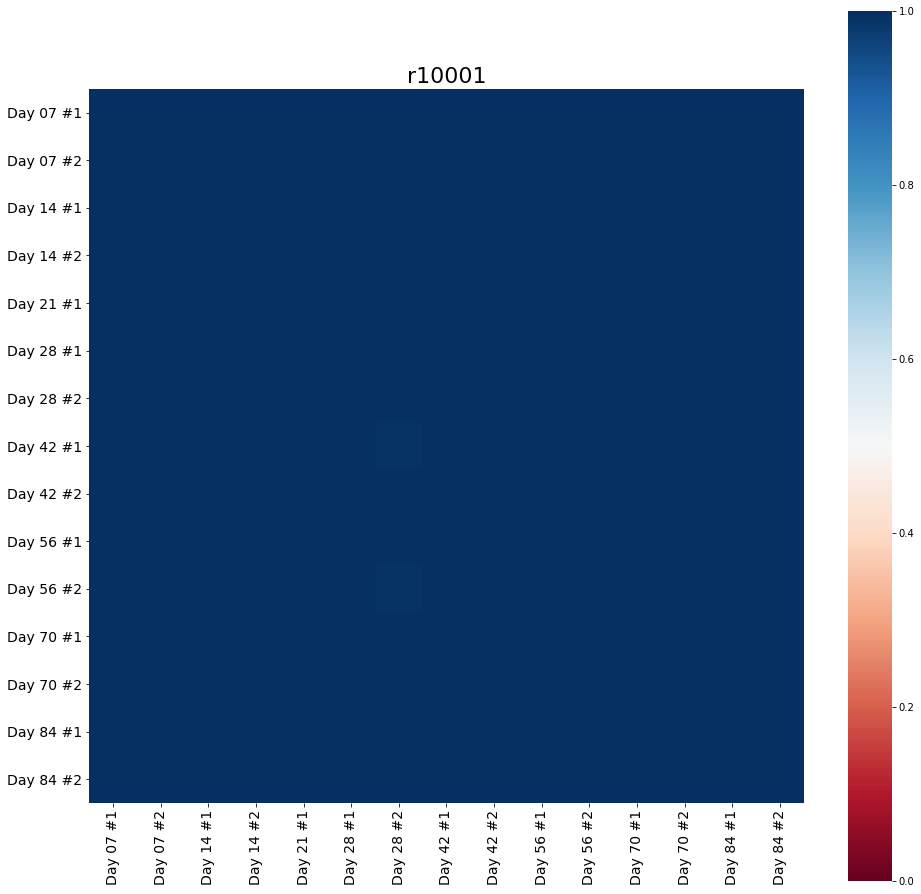

In [315]:
def heatmap(): 
    df = pd.read_csv(mhFolder + "/" + "mhReferenceMatrix_2000reads_" + str(replicates) + "reps_" + animal1name + ".csv", index_col = [0])
    plt.figure(figsize = (16,16))
    plt.xticks(rotation=90, fontsize='14')
    plt.yticks(rotation=90, fontsize='14')
    plt.title(animal1name, fontsize='22')
    sb.heatmap(df, cmap='RdBu', robust=True, square=True, vmin=0.0, vmax=1.0)
    
MHheatmap = heatmap()

# Experimental Permutation --> Morisita-Horn Similarity Index Animal 1

This portion of the code will take the permuted samples from the experimental Morisita-Horn subsamples and will use it to run Morisita-Horn on them. 

In [5]:
############NOW CREATING AN EMPTY NUMPY ARRAY TO BE USED LATER TO APPEND OUR VALUES TO################################ 

experimental1_array = np.zeros(shape=(numsamples_animal1,numsamples_animal1))

############DEFINING THE FUNCTION#####################################################################################

def experimental1_permutation(): 
    
###########NOW OPENING THE FIRST FILE TO EXTRACT THE BARCODES AND ADD THEM TO THE TOTAL POOL##########################    
    
    #creating counters for loop 1 and loop 2 so that we can use them to plug in the values to the empty numpy array
    counter1 = 0
    
    #make a list of all of the file names so we can use it for an index column and row later on
    experimental1_file_names = []
    
    for i in animal_1_folders: 
            
        #creates an empty list that we can store our barcodes in and pick from later
        all_barcodes1 = []

        #adding 1 to the first counter
        counter1 = counter1 + 1
        
        #splitting the path name so we can make a list of all the samples as we iterate through the files
        split_i = re.split('/', i)
        sampleName = split_i[-1]

        #adding the file name to the list of filenames to use later for an index column and row
        experimental1_file_names.append(sampleName)
        print("The file_names list is: ")
        print(experimental1_file_names)

        #resetting counter two when we open a new first file so it only goes up to the value it needs to be at
        counter2 = 0
        
        #creates a list of all of the files in this directory
        directory = os.listdir(i)
        
        #filtering the list for only the second spreadsheet, which is the only one we will be using
        first_file1 = [s for s in directory if s.startswith("1_")]
        
        #converting the file name to a string
        string_first_file1 = ''.join(first_file1)
        
        #gives us the absolute full path to the first spreadsheet in that directory
        string_path_1 = os.path.join(i, string_first_file1)

        #converts this file to a pandas dataframe
        df1 = pd.read_csv(string_path_1, header=[0])
        
        #iterates through rows of the pandas dataframe
        #for index, row in df1.iterrows(): 

            #creates a "counts" value that gives the number of times that this barcode is found in that file
            #counts1 = row['Counts']
            #counts1 = int(counts1)

            #gives us the name of the barcode associated with the count right above
            #barcode1 = row['Barcode']

            #this appends all the barcode names to the list in the range that is given in the counts column
            #all_barcodes1.extend([barcode1 for x in range(counts1)])

        #convert all_barcodes to a numpy array 
        #array1 = np.array(all_barcodes1)

########NOW OPENING SECOND FILE#####################################################################################          
        for i in animal_1_folders: 
            
            #creates an empty list that we can store our barcodes in and pick from later
            all_barcodes2 = []

            #creates a list of all of the files in this directory
            directory = os.listdir(i)

            #filtering the list for only the second spreadsheet, which is the only one we will be using
            first_file2 = [s for s in directory if s.startswith("1_")]

            #converting the file name to a string
            string_first_file2 = ''.join(first_file2)

            #adding 1 to counter 2
            counter2 = counter2 + 1
            
            #gives us the absolute full path to the first spreadsheet in that directory (i)
            string_path_2 = os.path.join(i, string_first_file2)
            print("The first path is: " + string_path_1)
            print("The second path is: " + string_path_2)
            
            #converts this file to a pandas dataframe
            df2 = pd.read_csv(string_path_2, header=[0])
            
            #iterates through rows of the pandas dataframe
            #for index, row in df2.iterrows(): 

                #creates a "counts" value that gives the number of times that this barcode is found in that file
                #counts2 = row['Counts']
                #counts2 = int(counts2)

                #gives us the name of the barcode associated with the count right above
                #barcode2 = row['Barcode']

                #this appends all the barcode names to the list in the range that is given in the counts column
                #all_barcodes2.extend([barcode2 for x in range(counts2)])

            #convert all_barcodes to a numpy array 
            #array2 = np.array(all_barcodes2)
            
            print("The first counter is: ")
            print(counter1)
            print("The second counter is: ")
            print(counter2)
        
###########NOW SETTING THE LOOP THAT WILL RUN THIS PIPELINE IN REPLICATE##############################################
            
            #this is going to create a list of all M-H values creates during this step so we can find the median
            #value and append that to the Morisita-Horn array 
            MHreplicates = []
        
            #this is going to run the "picking" from the all_barcodes array a fixed number of times ("replicates" value)
            for x in range(0, replicates):
        
##########NOW RANDOMLY SELECTING OUR SET OF READS FROM BOTH FILES AND USES IT TO RUN M-H###############################     
    
                #numpy will randomly select 2000 elements from the first array
                #subsample1 = np.random.choice(array1, 2000, replace=False)

                #numpy will randomly select 2000 elements from the second array
                #subsample2 = np.random.choice(array2, 2000, replace=False)

                #splits the first list back up into the barcode name and subsequent counts
                #uniques1, counts1 = np.unique(subsample1, return_counts=True)

                #splits the second list back up into the barcode name and subsequent counts
                #uniques2, counts2 = np.unique(subsample2, return_counts=True)

                #zips the unique barcode identity to its subsequent count value in a dictionary
                #subsampleCounts1 = dict(zip(uniques1, counts1))

                #zips the unique barcode identity to its subsequent count value in a dictionary 
                #subsampleCounts2 = dict(zip(uniques2, counts2))

                #converts this dictionary to a pandas dataframe 
                #f1 = pd.DataFrame(subsampleCounts1.items(), columns=['Barcode', 'Counts'])

                #converts this dictionary to a pandas dataframe
                #f2 = pd.DataFrame(subsampleCounts2.items(), columns=['Barcode', 'Counts'])
        
####NOW CALCULATING MORISITA-HORN VALUES###########################################################################            

                #explicitly state the total counts (2000 due to permutation) for the large X value for the denominator
                X = 2000

                #convert the file to numpy for some of the later analysis
                file1 = df1.to_numpy()

                #explicitly state the total counts (2000 due to permutation) for the large Y value for the denominator
                Y = 2000

                #convert the second file to numpy for some of the later analysis
                file2 = df2.to_numpy()

                #merges the barcode lists from both of the original files so you can see them all in one list
                df1_df2 = pd.concat([df1, df2], ignore_index=True)

                #makes a list of all barcodes found in these two files
                barcodes = df1_df2["Barcode"].values

                #edits the list to all unique barcodes found in the two files 
                uniqueBarcodes = np.unique(barcodes)
                uniqueBarcodes.astype('|S16')

                #defining variables for later
                numerator = 0
                xSquared = 0
                ySquared = 0

                for f in uniqueBarcodes: 

                    #determining x and y values for the equation
                    x = 0
                    y = 0

                    #makes a first dataframe that has all string matches
                    matchRow1 = df1[df1['Barcode'].str.match(f)]

                    #since there might be multiple string matches, we need to filter for just the one we want
                    final1 = matchRow1[matchRow1['Barcode'] == f]

                    #if there is no barcode at all, you want to set that x value equal to zero
                    if final1.empty == True: 
                        x = 0
                    #otherwise, we want to set x equal to the counts
                    else:
                        x = final1['Counts'].values[0]

                    #this does the same thing with the second file
                    matchRow2 = df2[df2['Barcode'].str.match(f)]

                    #this once again makes a dataframe with all matches
                    final2 = matchRow2[matchRow2['Barcode'] == f]

                    #if there is no barcode, set the y value equal to zero
                    if final2.empty == True:
                        y = 0
                    else:
                        y = final2['Counts'].values[0]

                    #calculating the numerator (multiplying by 2 happens at the very end)
                    numerator = numerator + (x * y)  

                    #calculating the first part of the denominator (dividing comes later)
                    xSquared = xSquared + (x ** 2)

                    #calculating the first part of the denominator (dividing comes later)
                    ySquared = ySquared + (y ** 2)

                #FINAL CALCULATIONS FOR THIS PAIR OF FILES

                #multiplying the numerator sum by 2 to get the final numerator 
                numerator = numerator * 2

                #dividing the xSquared sum by X**2
                denomX = xSquared / (X ** 2)

                #dividing the ySquared sum by Y**2 
                denomY = ySquared / (Y ** 2)

                #adding the denomX and denomY values
                denomXplusY = denomX + denomY

                #final denominator value
                denominator = denomXplusY * (X*Y)

                #final MH value
                MH = numerator / denominator

                #printing the list of all the Morisita-Horn values for this pair of files
                MHreplicates.append(MH)

            print(MHreplicates)
            #finds the median value from this list
            MHmedian = statistics.median(MHreplicates)
            print(MHmedian)

            #adds the MH value to the current counter value's location in the empty numpy array
            experimental1_array[counter1-1, counter2-1] = MH
    print(experimental1_array)
    return experimental1_array, experimental1_file_names

experimental1_array, experimental1_file_names = experimental1_permutation()            

The file_names list is: 
['r10001 Day 56']
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 56/1_r10001 Day 56_pooledReplicatesCounts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 56/1_r10001 Day 56_pooledReplicatesCounts.csv
The first counter is: 
1
The second counter is: 
1
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
1.0
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 56/1_r10001 Day 56_pooledReplicatesCounts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 28/1_r10001 Day 28_pooledReplicatesCounts.csv
The first counter is: 
1
The second counter is: 
2
[0.5447924253439757, 0.5447924253439757, 0.5447924253439757, 0.5447924253439757, 0.5447924253439757, 0

[0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317]
0.9850008832119317
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 28/1_r10001 Day 28_pooledReplicatesCounts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 70/1_r10001 Day 70_pooledReplicatesCounts.csv
The first counter is: 
2
The second counter is: 
7
[0.454761987751392, 0.454761987751392, 0.454761987751392, 0.454761987751392, 0.454761987751392, 0.454761987751392, 0.454761987751392, 0.454761987751392, 0.454761987751392, 0.454761987751392]
0.454761987751392
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 28/1_r10001 Day 28_pooledReplicatesCounts.c

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
1.0
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 42/1_r10001 Day 42_pooledReplicatesCounts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 07/1_r10001 Day 07_pooledReplicatesCounts.csv
The first counter is: 
4
The second counter is: 
5
[0.9578593464672425, 0.9578593464672425, 0.9578593464672425, 0.9578593464672425, 0.9578593464672425, 0.9578593464672425, 0.9578593464672425, 0.9578593464672425, 0.9578593464672425, 0.9578593464672425]
0.9578593464672425
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 42/1_r10001 Day 42_pooledReplicatesCounts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 14/1_r10001 Day 14_poo

[0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317, 0.9850008832119317]
0.9850008832119317
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 14/1_r10001 Day 14_pooledReplicatesCounts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 21/1_r10001_Day_21_#1_Filtered_Barcode_Counts.csv
The first counter is: 
6
The second counter is: 
3
[0.8751109540094523, 0.8751109540094523, 0.8751109540094523, 0.8751109540094523, 0.8751109540094523, 0.8751109540094523, 0.8751109540094523, 0.8751109540094523, 0.8751109540094523, 0.8751109540094523]
0.8751109540094523
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 14/1_r10001 Day 14_pooledRep

[0.9907373221790926, 0.9907373221790926, 0.9907373221790926, 0.9907373221790926, 0.9907373221790926, 0.9907373221790926, 0.9907373221790926, 0.9907373221790926, 0.9907373221790926, 0.9907373221790926]
0.9907373221790926
The file_names list is: 
['r10001 Day 56', 'r10001 Day 28', 'r10001 Day 21', 'r10001 Day 42', 'r10001 Day 07', 'r10001 Day 14', 'r10001 Day 70', 'r10001 Day 84']
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 84/1_r10001 Day 84_pooledReplicatesCounts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed/r10001 Day 56/1_r10001 Day 56_pooledReplicatesCounts.csv
The first counter is: 
8
The second counter is: 
1
[0.9635112628860093, 0.9635112628860093, 0.9635112628860093, 0.9635112628860093, 0.9635112628860093, 0.9635112628860093, 0.9635112628860093, 0.9635112628860093, 0.9635112628860093, 0.9635112628860093]
0.963511262886009

# Pre-Heatmap Data Manipulation --> Experimental MH Animal 1

This section of code is going to use the output table from the previous kernel and manipulate the output such that it is ready to plot as a heatmap. 

In [6]:
def mhHeatmap(experimental1_array, experimental1_file_names):
    
    #eliminate the animal name from the axis titles
    experimental1_file_names = [i.split(' ')[1:4] for i in experimental1_file_names] 
    
    #makes a new list for the modified axis titles
    new_axis_labels = []
    
    #changes all of the names and modifies them and puts it in the new axis labels list
    for i in experimental1_file_names:
        new_axis_labels.append(' '.join(i))
    
    #uses the morisita-horn numpy array from the previous step as the dataframe, and then uses the list of all the 
    #file names as the row and column labels
    df = pd.DataFrame(experimental1_array, index=new_axis_labels, columns=list(new_axis_labels))
    df.sort_index(axis=0, ascending=True, inplace=True)
    df.sort_index(axis=1, ascending=True, inplace=True)
    
    #save this dataframe as a csv 
    df.to_csv(mhFolder + "/" + "mhExperimentalMatrixallreads_" + str(replicates) + "reps_" + animal1name + ".csv")

heatmap = mhHeatmap(experimental1_array, experimental1_file_names)

ValueError: Shape of passed values is (15, 15), indices imply (8, 8)

# Heatmap Experimental Permutation MH Values--Animal 1

This portion of the code will take the csv file from the previous kernel and it will plot it it in a heatmap.It is plotting all of the permuted samples 

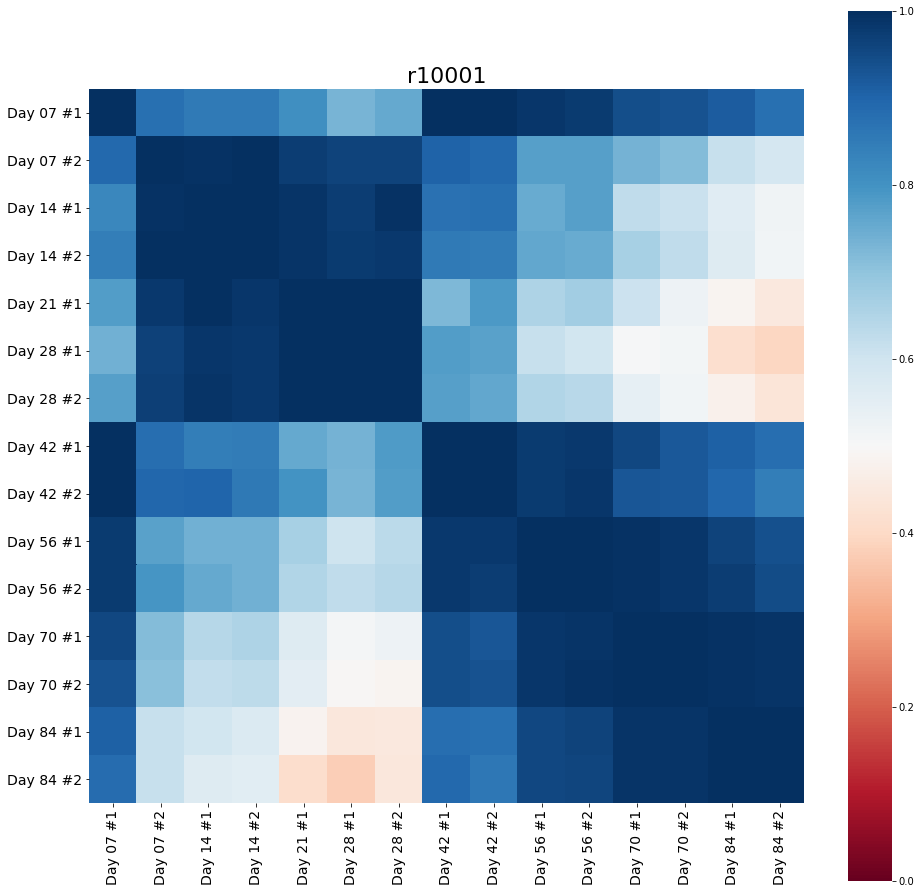

In [320]:
def heatmap(): 
    df = pd.read_csv(mhFolder + "/" + "mhExperimentalMatrix2000reads_" + str(replicates) + "reps_" + animal1name + ".csv", index_col = [0])
    plt.figure(figsize = (16,16))
    plt.xticks(rotation=90, fontsize='14')
    plt.yticks(rotation=90, fontsize='14')
    plt.title(animal1name, fontsize='22')
    sb.heatmap(df, cmap='RdBu', robust=True, square=True, vmin=0.0, vmax=1.0)
    
MHheatmap = heatmap()

# Wilcoxan Rank Sum Test--Animal 1

This portion of the code is going to take the two "heatmap" grids that were created in the Morisita-Horn step and its going to use them to calculate the Wilcoxan Rank Sum statistic and a p-value for the two. 

In [347]:
def WilcoxanRank1(): 
    #open the reference heatmap grid
    ref = pd.read_csv(mhFolder + "/mhReferenceMatrix_2000reads_" + str(replicates) + "reps_" + animal1name + ".csv", 
                     index_col = [0], low_memory = False)
    
    #open the experimental heatmap grid
    exp = pd.read_csv(mhFolder + "/mhExperimentalMatrix_2000reads_" + str(replicates) + "reps_" + animal1name + ".csv", 
                     index_col = [0], low_memory = False)
    
    print(ref)
    
    #converting the reference heatmap to a numpy array
    ref_np = ref.to_numpy()
    
    #converting the experimental heatmap to a numpy array
    exp_np = exp.to_numpy()
    
    #doing wilcoxan-rank sum test
    WRS = scipy.stats.ranksums(ref_np, exp_np)
    print(WRS)
    
WR1 = WilcoxanRank1()

FileNotFoundError: [Errno 2] File b'/Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step9.Morisita-Horn/mhReferenceMatrix_2000reads_10reps_cy0428.csv' does not exist: b'/Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step9.Morisita-Horn/mhReferenceMatrix_2000reads_10reps_cy0428.csv'

# Reference Permutations --> Reference Morisita-Horn Calculation Animal 2

This kernel going to look at every single combination of files. With each combination of 2 files, it is going to pool all of the barcodes from the two original files, and then it's going to pull out 2000 reads to make our two "reference" files. These will stand in place of the two original files, as a "reference" distribution. This way, when we are doing our Morisita-Horn and Simpson's Diversity Index calculations, we will be able to see how these "experimental" distributions that are pulled from only their original file compare to those that were pooled with both and pulled from there. If there is a huge difference between the average Morisita-Horn value in the experimental groups and in the reference groups, it is very possible that you have a distribution that is different than would be expected with just an average draw from those two samples. 

In [330]:
############NOW CREATING AN EMPTY NUMPY ARRAY TO BE USED LATER TO APPEND OUR VALUES TO################################ 

reference2_array = np.zeros(shape=(numsamples_animal2,numsamples_animal2))

############DEFINING THE FUNCTION#####################################################################################

def reference_permutation2():
    
###########NOW OPENING THE FIRST FILE TO EXTRACT THE BARCODES AND ADD THEM TO THE TOTAL POOL##########################    
    
    #creating counters for loop 1 and loop 2 so that we can use them to plug in the values to the empty numpy array
    counter1 = 0
    
    #make a list of all of the file names so we can use it for an index column and row later on
    reference2_file_names = []
    
    for i in animal_2_folders: 
        
        all_barcodes = []
        
        #adding 1 to the first counter
        counter1 = counter1 + 1
        
        #splitting the path name so we can make a list of all the samples as we iterate through the files
        split_i = re.split('/', i)
        sampleName = split_i[-1]

        #adding the file name to the list of filenames to use later for an index column and row
        reference2_file_names.append(sampleName)
        print("The file_names list is: ")
        print(reference2_file_names)

        #resetting counter two when we open a new first file so it only goes up to the value it needs to be at
        counter2 = 0

        #creates a list of all of the files in this directory
        directory = os.listdir(i)
        
        #filtering the list for only the second spreadsheet, which is the only one we will be using
        first_file = [s for s in directory if s.startswith("1_")]
        
        #converting the file name to a string
        string_first_file = ''.join(first_file)
        
        #gives us the absolute full path to the first spreadsheet in that directory
        string_path_1 = os.path.join(i, string_first_file)

        #converts this file to a pandas dataframe
        df1 = pd.read_csv(string_path_1, header=[0])

        
############NOW OPENING THE SECOND FILE TO EXTRACT THE BARCODES AND ADD THEM TO THE TOTAL POOL########################            

        #we are moving through the directory for the second time now...
        for i in animal_2_folders: 
            
            #resets the all_barcodes list so we don't have old data hanging out in it
            all_barcodes = []
            
            #creates a list of all the files in this directory
            directory = os.listdir(i)
            
            #filtering the list for only the second spreadsheet, which is the only one we will be using
            first_file2 = [s for s in directory if s.startswith("1_")]
            
            #converting the file name to a string
            string_first_file2 = ''.join(first_file2)
            
            #adding 1 to counter 2
            counter2 = counter2 + 1
            
            #gives us the absolute full path to the first spreadsheet in that directory (i)
            string_path_2 = os.path.join(i, string_first_file2)
            print("The first path is: " + string_path_1)
            print("The second path is: " + string_path_2)
            
            #converts string_path_2 to a pandas dataframe
            df2 = pd.read_csv(string_path_2, header=[0])

###########NOW DEFINING THE LIST AND APPENDING ALL OF THE BARCODES TO THE LIST AS WELL################################
    
            #creates an empty list for the barcodes to be stored in
            all_barcodes = []
            
            #iterates through rows of the first pandas dataframe
            for index, row in df1.iterrows(): 

                #creates a "counts" value that gives the number of times that this barcode is found in that file
                counts1 = row['Counts']
                counts1 = int(counts1)

                #gives us the name of the barcode associated with the count right above
                barcode1 = row['Barcode']

                #this appends all the barcode names to the list in the range that is given in the counts column
                all_barcodes.extend([barcode1 for x in range(counts1)])
            
            #iterates through rows of the pandas dataframe
            for index, row in df2.iterrows(): 

                #creates a "counts" value that gives the number of times that this barcode is found in that file
                counts2 = row['Counts']
                counts2 = int(counts2)

                #gives us the name of the barcode associated with the count right above
                barcode2 = row['Barcode']

                #this appends all the barcode names to the list in the range that is given in the counts column
                all_barcodes.extend([barcode2 for x in range(counts2)])
                
            #convert all_barcodes to a numpy array 
            array2 = np.array(all_barcodes)
            
            print("Counter 1 equals: ") 
            print(counter1)

            print("Counter 2 equals: ")
            print(counter2)

###########NOW SETTING THE LOOP THAT WILL RUN THIS PIPELINE IN REPLICATE##############################################
            
            #this is going to create a list of all M-H values creates during this step so we can find the median
            #value and append that to the Morisita-Horn array 
            MHreplicates = []
        
            #this is going to run the "picking" from the all_barcodes array a fixed number of times ("replicates" value)
            for x in range(0, replicates):
                
###########NOW SPLITTING THE POOL UP INTO 2 POOLS OF 2000 READS AND PREPARING THEM FOR MORISITA-HORN##################

                #numpy will randomly select 2000 elements from the array, which makes a 2,000 count subset of the original
                subsample1 = np.random.choice(array2, 2000, replace=False)

                #numpy will once again randomly select 2000 elements from the array, so we have a second reference frame
                subsample2 = np.random.choice(array2, 2000, replace=False)

                #splits the first list back up into the barcode name and subsequent counts
                uniques1, counts1 = np.unique(subsample1, return_counts=True)

                #splits the second list back up into the barcode name and subsequent counts
                uniques2, counts2 = np.unique(subsample2, return_counts=True)

                #zips the unique barcode identity to its subsequent count value in a dictionary for the first pool
                subsampleCounts1 = dict(zip(uniques1, counts1))

                #zips the unique barcode identity to its subsequent count value in a dictionary for the second pool 
                subsampleCounts2 = dict(zip(uniques2, counts2))

                #converts this first dictionary to a pandas dataframe so we can use it for Morisita-Horn computation
                f1 = pd.DataFrame(subsampleCounts1.items(), columns=['Barcode', 'Counts'])

                #converts this second dictionary to a pandas dataframe so we can use it for Morisita-Horn computation
                f2 = pd.DataFrame(subsampleCounts2.items(), columns=['Barcode', 'Counts'])

####NOW CALCULATING MORISITA-HORN VALUES###########################################################################            

                #explicitly state the total counts (2000 due to permutation) for the large X value for the denominator
                X = 2000

                #convert the file to numpy for some of the later analysis
                file1 = f1.to_numpy()

                #explicitly state the total counts (2000 due to permutation) for the large Y value for the denominator
                Y = 2000

                #convert the second file to numpy for some of the later analysis
                file2 = f2.to_numpy()

                #merges the barcode lists from both of the original files so you can see them all in one list
                f1_f2 = pd.concat([f1, f2], ignore_index=True)

                #makes a list of all barcodes found in these two files
                barcodes = f1_f2["Barcode"].values

                #edits the list to all unique barcodes found in the two files 
                uniqueBarcodes = np.unique(barcodes)
                uniqueBarcodes.astype('|S16')

                #defining variables for later
                numerator = 0
                xSquared = 0
                ySquared = 0

                for f in uniqueBarcodes: 

                    #determining x and y values for the equation
                    x = 0
                    y = 0

                    #makes a first dataframe that has all string matches
                    matchRow1 = f1[f1['Barcode'].str.match(f)]

                    #since there might be multiple string matches, we need to filter for just the one we want
                    final1 = matchRow1[matchRow1['Barcode'] == f]

                    #if there is no barcode at all, you want to set that x value equal to zero
                    if final1.empty == True: 
                        x = 0
                    #otherwise, we want to set x equal to the counts
                    else:
                        x = final1['Counts'].values[0]

                    #this does the same thing with the second file
                    matchRow2 = f2[f2['Barcode'].str.match(f)]

                    #this once again makes a dataframe with all matches
                    final2 = matchRow2[matchRow2['Barcode'] == f]

                    #if there is no barcode, set the y value equal to zero
                    if final2.empty == True:
                        y = 0
                    else:
                        y = final2['Counts'].values[0]

                    #calculating the numerator (multiplying by 2 happens at the very end)
                    numerator = numerator + (x * y)  

                    #calculating the first part of the denominator (dividing comes later)
                    xSquared = xSquared + (x ** 2)

                    #calculating the first part of the denominator (dividing comes later)
                    ySquared = ySquared + (y ** 2)

                #FINAL CALCULATIONS FOR THIS PAIR OF FILES

                #multiplying the numerator sum by 2 to get the final numerator 
                numerator = numerator * 2

                #dividing the xSquared sum by X**2
                denomX = xSquared / (X ** 2)

                #dividing the ySquared sum by Y**2 
                denomY = ySquared / (Y ** 2)

                #adding the denomX and denomY values
                denomXplusY = denomX + denomY

                #final denominator value
                denominator = denomXplusY * (X*Y)

                #final MH value
                MH = numerator / denominator
                
                #printing the list of all the Morisita-Horn values for this pair of files
                MHreplicates.append(MH)
            
            print(MHreplicates)
            #finds the median value from this list
            MHmedian = statistics.median(MHreplicates)
            print(MHmedian)

            #adds the MH value to the current counter value's location in the empty numpy array
            reference2_array[counter1-1, counter2-1] = MH
    print(reference2_array)
    return reference2_array, reference2_file_names
    


reference2_array, reference2_file_names = reference_permutation2()

The file_names list is: 
['cy0575 Day 42 #2']
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 42 #2/1_cy0575_Day_42_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 42 #2/1_cy0575_Day_42_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
1
Counter 2 equals: 
1
[0.999623889909738, 0.999866418337152, 0.9997613908066907, 0.999638061062191, 0.9987917971657575, 0.9997428862107614, 0.9996925338916585, 0.9996821029339924, 0.9997044048995998, 0.9998880108106898]
0.9996984693956291
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 42 #2/1_cy0575_Day_42_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_D

[0.9992026490295359, 0.9993941415791431, 0.9994177536798888, 0.9985056689950368, 0.9994191210855194, 0.9993840788498813, 0.9993635894153146, 0.9992869596419157, 0.9994409058686726, 0.9990196462281714]
0.999373834132598
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 42 #2/1_cy0575_Day_42_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 24 #2/1_cy0575_Day_24_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
1
Counter 2 equals: 
14
[0.9989388555557168, 0.9990061869398157, 0.9996624631822231, 0.9991809632966999, 0.9994805620730778, 0.9998099751962333, 0.9983131228388131, 0.9998007462515692, 0.9992257126216204, 0.9997861217209535]
0.9993531373473491
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.Creati

[0.9558777029163525, 0.9596511150305637, 0.9552314983594604, 0.9484953277904495, 0.9599143137120849, 0.9596053923329263, 0.9496672010882767, 0.950198492880405, 0.959037052740678, 0.9665195821803407]
0.9574573778285153
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 03 #2/1_cy0575_Day_03_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 03 #1/1_cy0575_Day_03_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
2
Counter 2 equals: 
9
[0.9340804421246546, 0.9351354612924638, 0.9514689365726784, 0.9293742452859398, 0.933435004934063, 0.9360594108221374, 0.9459182778086519, 0.9437643020594964, 0.9465317919075145, 0.9424623942103532]
0.9392609025162453
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingS

Counter 1 equals: 
3
Counter 2 equals: 
4
[0.9228244837758112, 0.9371201157742403, 0.9286207596993704, 0.9248049094628382, 0.9318062311029316, 0.9386839005443953, 0.8757818501042466, 0.9305267280203641, 0.9365205241493902, 0.938290966118385]
0.9311664795616479
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 56 #2/1_cy0575_Day_56_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 24 #1/1_cy0575_Day_24_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
3
Counter 2 equals: 
5
[0.9947369750506997, 0.9964116106224844, 0.9953343393345266, 0.996795892883953, 0.9970431006566759, 0.9946803794662648, 0.9979155381790814, 0.9966908997943963, 0.9967794358688803, 0.9964026976315458]
0.9965512552084403
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analys

[0.9308481691673793, 0.9278591130914493, 0.927112623945538, 0.918212166172107, 0.9222015070302183, 0.9388636854612227, 0.9248664054150338, 0.9185289735748451, 0.9198168099403129, 0.9322804314329738]
0.9259895146802859
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 56 #2/1_cy0575_Day_56_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 70 #2/1_cy0575_Day_70_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
3
Counter 2 equals: 
18
[0.9992463164032487, 0.9988826772913242, 0.9997329916324288, 0.9996891472079855, 0.9990404628355735, 0.9975884265347444, 0.9999661861788991, 0.9975854910958156, 0.99998163728523, 0.9993243703658943]
0.9992853433845714
The file_names list is: 
['cy0575 Day 42 #2', 'cy0575 Day 03 #2', 'cy0575 Day 56 #2', 'cy0575 Day 10 #1']
The first pa

Counter 1 equals: 
4
Counter 2 equals: 
12
[0.7830010493179433, 0.8115313653136531, 0.7838169186759297, 0.8141867438734361, 0.8182959814528593, 0.804765800777255, 0.8054945054945055, 0.8278063655422147, 0.8158055329536208, 0.811334002006018]
0.8114326836598356
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 10 #1/1_cy0575_Day_10_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 17 #1/1_cy0575_Day_17_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
4
Counter 2 equals: 
13
[0.8974762520375471, 0.8822908728530396, 0.8782638969478938, 0.8911147902869757, 0.8924231787006535, 0.8935387942687213, 0.8721940622737147, 0.8940852012674568, 0.8997035573122529, 0.8907668589048136]
0.8917689844938146
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Anal

[0.9977581767991747, 0.9955337337314947, 0.9979372848061067, 0.9980110930584346, 0.9973219923215931, 0.9980801790370178, 0.9966244060325131, 0.998549194489154, 0.9969018952771244, 0.9974676390353118]
0.9976129079172432
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 24 #1/1_cy0575_Day_24_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 70 #1/1_cy0575_Day_70_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
5
Counter 2 equals: 
8
[0.9979318818074056, 0.9957278063462403, 0.9955953734278857, 0.9973564757971501, 0.9947440380132688, 0.9969933336950563, 0.9966759465478842, 0.997949651776057, 0.9932384893760576, 0.9951623666475237]
0.9962018764470622
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.Creating

[0.9029044824695498, 0.9113917706610535, 0.9005991552892645, 0.9063061265216523, 0.8966343893955062, 0.9179121960361711, 0.9105098855359003, 0.9039996244484086, 0.9067329984544049, 0.8980769230769231]
0.9051528754850304
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 14 #1/1_cy0575_Day_14_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 56 #2/1_cy0575_Day_56_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
6
Counter 2 equals: 
3
[0.9661217376872331, 0.9630503144654088, 0.9726469323114222, 0.9651425345752187, 0.9616115228055526, 0.9719247406660787, 0.9628280504430811, 0.970811171444986, 0.963897827835881, 0.9661354581673307]
0.9656321361312259
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.Creating

Counter 1 equals: 
6
Counter 2 equals: 
15
[0.8730941114616193, 0.8815522544336104, 0.8864224695832255, 0.8768680961663418, 0.877905386929177, 0.8809476008833568, 0.8580337747880318, 0.8566040323686737, 0.8783464566929133, 0.8991868885783256]
0.8781259218110451
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 14 #1/1_cy0575_Day_14_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 14 #2/1_cy0575_Day_14_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
6
Counter 2 equals: 
16
[0.8809466166323687, 0.88325256466738, 0.884836265884653, 0.8987437661763776, 0.8745971111376389, 0.8735117142491359, 0.8830581884376373, 0.8745451291534928, 0.8805569430569432, 0.8629492567270903]
0.880751779844656
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysi

[0.9980850138131909, 0.9985542588218711, 0.9985176475570933, 0.9992614834164295, 0.9989454934093339, 0.9989577564070289, 0.9990756555377325, 0.9986016742564912, 0.9976930991610028, 0.998805406498974]
0.9987035403777326
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 21 #1/1_cy0575_Day_21_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 56 #1/1_cy0575_Day_56_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
7
Counter 2 equals: 
11
[0.9981407150410709, 0.9978733306185541, 0.9992075938645599, 0.9989395742008395, 0.9997422912986321, 0.9989371779184265, 0.9985032326190689, 0.9986301008113763, 0.9998817915636593, 0.9981880297172934]
0.9987836393649014
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.Creati

[0.9968673951156783, 0.9928234148492476, 0.9976122548596341, 0.9968046355236877, 0.9971195521965457, 0.9952109278757979, 0.9984097901614408, 0.998714082787151, 0.9985178259322025, 0.9955020794938604]
0.996993473656112
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 70 #1/1_cy0575_Day_70_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 14 #1/1_cy0575_Day_14_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
8
Counter 2 equals: 
6
[0.9604067557703441, 0.9599789230692026, 0.9564568969732533, 0.9557408899208644, 0.9608954162008334, 0.9403875860132004, 0.9526708901323734, 0.9448908742200964, 0.9523171440851514, 0.9514725404395497]
0.9542058900266188
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.Creating

[0.9997582554789531, 0.9997241444336424, 0.9990525958429708, 0.9997639133217332, 0.9997385689430132, 0.9998927832814258, 0.999036313849755, 0.9979741410642554, 0.9990792617052353, 0.9988387077250522]
0.9994017030694389
The file_names list is: 
['cy0575 Day 42 #2', 'cy0575 Day 03 #2', 'cy0575 Day 56 #2', 'cy0575 Day 10 #1', 'cy0575 Day 24 #1', 'cy0575 Day 14 #1', 'cy0575 Day 21 #1', 'cy0575 Day 70 #1', 'cy0575 Day 03 #1']
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 03 #1/1_cy0575_Day_03_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 42 #2/1_cy0575_Day_42_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
9
Counter 2 equals: 
1
[0.9983683704314372, 0.9992661739302338, 0.9986350297860613, 0.9988736240122972, 0.9993304039825673, 0.9977369966060022, 0.9991612

[0.9275763328078248, 0.9405052722718699, 0.9225214742821943, 0.9302278481012658, 0.9483628050830364, 0.9322325535223852, 0.9446919200130062, 0.9427905427905428, 0.9351398193513982, 0.9390702673653097]
0.937105043358354
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 03 #1/1_cy0575_Day_03_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 24 #2/1_cy0575_Day_24_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
9
Counter 2 equals: 
14
[0.9676592353929567, 0.9706171434483473, 0.9590893216477357, 0.9644418992086632, 0.9657023611181232, 0.9643546584481999, 0.9781296753912619, 0.961887539826057, 0.9679223969446487, 0.9709383212243005]
0.96668079825554
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingS

[0.9986192220284827, 0.997263328603284, 0.9986874316692369, 0.9993578192595474, 0.9989191094651184, 0.9990107901697529, 0.9987985073637018, 0.9988718580140703, 0.9986736515543019, 0.9992198224776392]
0.998835182688886
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 42 #1/1_cy0575_Day_42_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 70 #1/1_cy0575_Day_70_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
10
Counter 2 equals: 
8
[0.9996605386769346, 0.9998493132320649, 0.9998287276545614, 0.9997655441285207, 0.9998095249274247, 0.999928246210153, 0.999979419525066, 0.9999643383023689, 0.9998156458383229, 0.9997451863549087]
0.9998221867464422
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingS

[0.9990921297912416, 0.999707094719031, 0.9988692244983828, 0.9997274894969911, 0.9995717453957726, 0.9985808095967814, 0.9997750119421813, 0.9994869599642096, 0.9996923926124168, 0.9998745600847643]
0.9996320690040947
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 56 #1/1_cy0575_Day_56_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 03 #2/1_cy0575_Day_03_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
11
Counter 2 equals: 
2
[0.9980835101913474, 0.998495437579192, 0.9981794818336542, 0.999140323663432, 0.9988414441257026, 0.9981700460282316, 0.9949777731565821, 0.9975946671255936, 0.9991494350486171, 0.998235969534717]
0.9982077256841857
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingS

[0.9993199309836878, 0.9991909639244617, 0.9995121584792849, 0.9981471620517355, 0.9998675669876351, 0.9997263243709388, 0.9991832852520882, 0.9972017486964798, 0.9992195126827107, 0.9987068727632422]
0.9992052383035862
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 56 #1/1_cy0575_Day_56_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 10 #2/1_cy0575_Day_10_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
11
Counter 2 equals: 
15
[0.9975405979373577, 0.9991773760122844, 0.9946800626081889, 0.9984840865976288, 0.9950575677390007, 0.9985862027437952, 0.9966250906015944, 0.9989533489015257, 0.9987353707915025, 0.998514783002377]
0.9984994348000029
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.Creat

[0.887462277091907, 0.9058204914618907, 0.9142842504354954, 0.8971428571428571, 0.9048812377424277, 0.9192462987886943, 0.8954472415640065, 0.9027082973952044, 0.8894385097089933, 0.9079928039064508]
0.903794767568816
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 07 #1/1_cy0575_Day_07_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 03 #1/1_cy0575_Day_03_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
12
Counter 2 equals: 
9
[0.92482298199474, 0.9235678526388199, 0.9257953268493044, 0.9137891781133792, 0.920344236887185, 0.9245385873374348, 0.9448597077714758, 0.9155169856104435, 0.9279056799171512, 0.9354325699745547]
0.9246807846660874
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSu

[0.9132880129114296, 0.9055398782117927, 0.9043636542529642, 0.905311211466719, 0.9005807994533652, 0.913929411764706, 0.9079611465574707, 0.9036608863198459, 0.9122246747757479, 0.894767190428139]
0.9054255448392559
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 17 #1/1_cy0575_Day_17_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 56 #2/1_cy0575_Day_56_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
13
Counter 2 equals: 
3
[0.9527946170031039, 0.9626593261923284, 0.9582327907690957, 0.9633249858631552, 0.956715342806627, 0.9583316695284111, 0.9546127394047049, 0.9483424455436954, 0.956878441432078, 0.9551430433512371]
0.9567968921193525
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSu

Counter 1 equals: 
13
Counter 2 equals: 
15
[0.8866479597801941, 0.9038870724998702, 0.9000682904620988, 0.8842560461267419, 0.8949891067538126, 0.9028026551469813, 0.8927441292399934, 0.9039384193599411, 0.914708722240103, 0.8978710994459026]
0.8989696949540007
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 17 #1/1_cy0575_Day_17_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 14 #2/1_cy0575_Day_14_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
13
Counter 2 equals: 
16
[0.9056105293496012, 0.9038067734313469, 0.8959599570968895, 0.8980041229385306, 0.8992850162028703, 0.9131181974412832, 0.8952600489842962, 0.9081867620400764, 0.9174770642201835, 0.919271727928547]
0.9047086513904741
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_An

[0.9683750428522454, 0.9704848676649399, 0.9709535050805707, 0.962904668809437, 0.9706458926410173, 0.9696856487164434, 0.969594775440287, 0.9683860791354835, 0.9663116384104621, 0.9746458509045218]
0.9696402120783651
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 24 #2/1_cy0575_Day_24_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 42 #1/1_cy0575_Day_42_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
14
Counter 2 equals: 
10
[0.9988816348727566, 0.9994831397078829, 0.9992323785593286, 0.9984210109354554, 0.9984204231897005, 0.999504886932248, 0.9989358341231439, 0.9993876306752398, 0.9994680388805642, 0.9987189626267899]
0.9990841063412362
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.Creatin

[0.9567049491861523, 0.9462865497076023, 0.9561119371282922, 0.946213554952138, 0.9468801007989464, 0.9465335833942592, 0.9437408345553926, 0.9448931116389546, 0.9389457492752766, 0.9421047472800339]
0.9462500523298701
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 10 #2/1_cy0575_Day_10_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 10 #1/1_cy0575_Day_10_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
15
Counter 2 equals: 
4
[0.8428384442782348, 0.8233315148208765, 0.8382702505028341, 0.8243978243978244, 0.8452592329545454, 0.8207694426590761, 0.8143170597915523, 0.8369995398067188, 0.839317613433369, 0.84476628219582]
0.8376348951547765
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingS

Counter 1 equals: 
15
Counter 2 equals: 
16
[0.8542761586239848, 0.84527042756266, 0.8549560853199498, 0.8403751971445174, 0.8551430781129157, 0.8483951012567037, 0.836710178585729, 0.8539708265802269, 0.8656011337689946, 0.8507163765213372]
0.8523436015507821
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 10 #2/1_cy0575_Day_10_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 21 #2/1_cy0575_Day_21_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
15
Counter 2 equals: 
17
[0.9189025924993708, 0.9053233656113594, 0.9010385158298044, 0.9069175747683741, 0.9073919833420095, 0.9200057446502946, 0.8995928096136657, 0.9118730972600545, 0.8864016206634591, 0.8989441930618403]
0.9061204701898667
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Ana

[0.9811728395061726, 0.9551209372637944, 0.9837077004281274, 0.9792997816818497, 0.9827377019640819, 0.9785457411695158, 0.9755398479438412, 0.9766126330438366, 0.9748082193420218, 0.9796779185053587]
0.9789227614256828
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 14 #2/1_cy0575_Day_14_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 56 #1/1_cy0575_Day_56_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
16
Counter 2 equals: 
11
[0.9984084150022152, 0.9991319765567611, 0.9991211309670411, 0.9990795275419422, 0.9984142496511615, 0.9983723690701307, 0.9984791184944458, 0.9993193219683427, 0.9982453722842313, 0.9968329081632653]
0.9984466840728037
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.Crea

Counter 1 equals: 
17
Counter 2 equals: 
4
[0.9068298263940704, 0.9043614020950846, 0.9037513828824298, 0.8930049668874174, 0.8860235918909258, 0.9063003112589889, 0.884306431613564, 0.9156491602239403, 0.9092185775905306, 0.9086618967879432]
0.9053308566770368
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 21 #2/1_cy0575_Day_21_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 24 #1/1_cy0575_Day_24_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
17
Counter 2 equals: 
5
[0.9937451923450477, 0.9908028977804479, 0.9915975995249213, 0.994887395463431, 0.9914142512953159, 0.9945608641589173, 0.9943392401577362, 0.9913244978977632, 0.9920063858119968, 0.9954582363659675]
0.9928757890785223
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Anal

Counter 1 equals: 
17
Counter 2 equals: 
17
[0.9086777568170127, 0.9239627572688663, 0.9295536890645586, 0.9092005155282087, 0.9107846926942404, 0.9299738475350325, 0.9308498519024835, 0.927162862858776, 0.922612219928118, 0.9205870526739043]
0.9232874885984922
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 21 #2/1_cy0575_Day_21_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 70 #2/1_cy0575_Day_70_#2_Filtered_Barcode_Counts.csv
Counter 1 equals: 
17
Counter 2 equals: 
18
[0.9953795406384857, 0.9964748159483912, 0.9968496722528982, 0.9971104383666688, 0.997816980231429, 0.9934718206520663, 0.9975703982137407, 0.9961910699975818, 0.9949511077355934, 0.9971373565912214]
0.9966622441006447
The file_names list is: 
['cy0575 Day 42 #2', 'cy0575 Day 03 #2', 'cy057

[0.9981484757522213, 0.999080369864188, 0.999074180907275, 0.9998967130872246, 0.9991666384034341, 0.9995669687106774, 0.9986568409580492, 0.9998444797571397, 0.9993344251592953, 0.9998539554091092]
0.9992505317813647
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 70 #2/1_cy0575_Day_70_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.CreatingSummarySpreadsheets/cy0575 Day 07 #1/1_cy0575_Day_07_#1_Filtered_Barcode_Counts.csv
Counter 1 equals: 
18
Counter 2 equals: 
12
[0.9986480935130896, 0.9974175493952372, 0.9984240111020107, 0.9992161703945412, 0.9994679014136085, 0.9990046267350257, 0.9974773087264833, 0.9982988273909845, 0.999213168545157, 0.9990450983763602]
0.9988263601240577
The first path is: /Users/agolfinos/Desktop/Research_Projects/IV_SDI_Analysis_exp4924/IV_Data_Analysis/Step6.Creatin

# Pre-Heatmap Data Manipulation--Reference Permutations Animal 2

This portion of the code will take the reference permutations calculated in the previous kernel and it will do some simple manipulation, including renaming, sorting and saving a new file in preparation for creation of the heatmap in the next step. 

In [331]:
def mhHeatmap(reference2_array, reference2_file_names):
    
    #eliminate the animal name from the axis titles
    reference2_file_names = [i.split(' ')[1:4] for i in reference2_file_names] 
    
    #makes a new list for the modified axis titles
    new_axis_labels = []
    
    #changes all of the names and modifies them and puts it in the new axis labels list
    for i in reference2_file_names:
        new_axis_labels.append(' '.join(i))
    
    #uses the morisita-horn numpy array from the previous step as the dataframe, and then uses the list of all the 
    #file names as the row and column labels
    df = pd.DataFrame(reference2_array, index=new_axis_labels, columns=list(new_axis_labels))
    df.sort_index(axis=0, ascending=True, inplace=True)
    df.sort_index(axis=1, ascending=True, inplace=True)
    
    #save this dataframe as a csv 
    df.to_csv(mhFolder + "/" + "mhReferenceMatrix_2000reads_" + str(replicates) + "reps_" + animal2name + ".csv")

heatmap = mhHeatmap(reference2_array, reference2_file_names)

# Heatmap--Reference Permutations Animal 2

This portion of the code is going to take the csv file created in the previous kernel and it will plot it as a heatmap created from the seaborn package. 

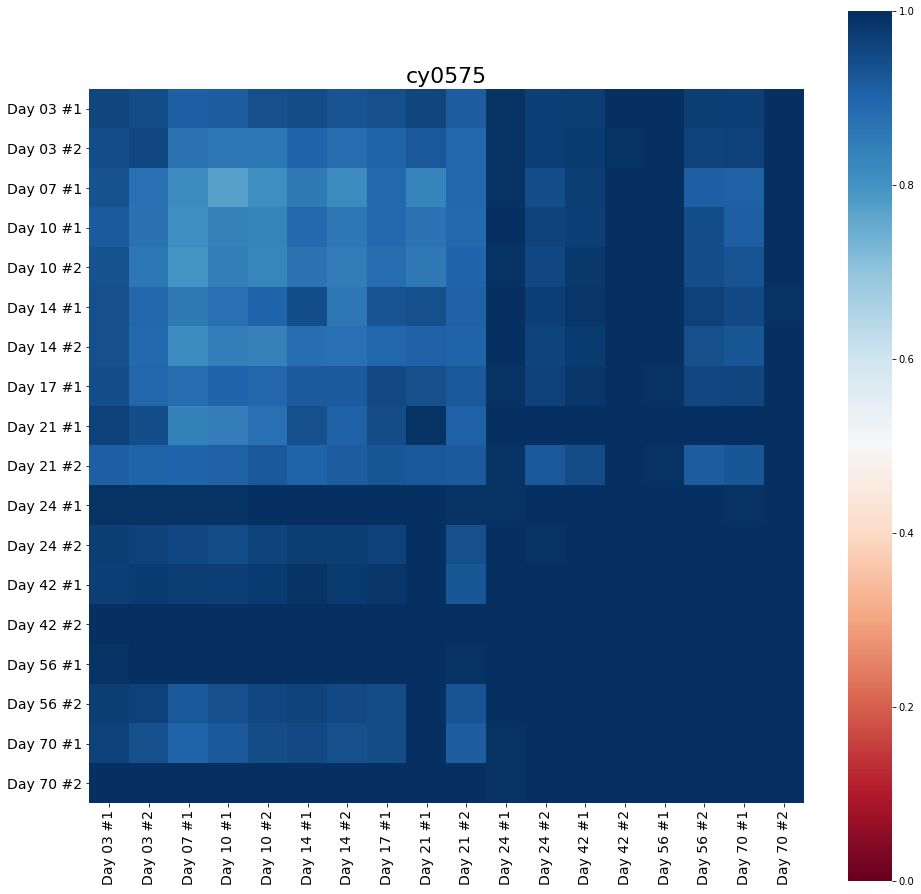

In [332]:
def heatmap(): 
    df = pd.read_csv(mhFolder + "/" + "mhReferenceMatrix_2000reads_" + str(replicates) + "reps_" + animal2name + ".csv", index_col = [0])
    plt.figure(figsize = (16,16))
    plt.xticks(rotation=90, fontsize='14')
    plt.yticks(rotation=90, fontsize='14')
    plt.title(animal2name, fontsize='22')
    sb.heatmap(df, cmap='RdBu', robust=True, square=True, vmin=0.0, vmax=1.0)
    
MHheatmap = heatmap()

# Experimental Permutation Morisita-Horn--Animal 2

In [23]:
############NOW CREATING AN EMPTY NUMPY ARRAY TO BE USED LATER TO APPEND OUR VALUES TO################################ 

experimental2_array = np.zeros(shape=(numsamples_animal2,numsamples_animal2))

############DEFINING THE FUNCTION#####################################################################################

def experimental2_permutation(): 
    
###########NOW OPENING THE FIRST FILE TO EXTRACT THE BARCODES AND ADD THEM TO THE TOTAL POOL##########################    
    
    #creating counters for loop 1 and loop 2 so that we can use them to plug in the values to the empty numpy array
    counter1 = 0
    
    #make a list of all of the file names so we can use it for an index column and row later on
    experimental2_file_names = []
    
    for i in animal_2_folders: 
            
        #creates an empty list that we can store our barcodes in and pick from later
        all_barcodes1 = []

        #adding 1 to the first counter
        counter1 = counter1 + 1
        
        #splitting the path name so we can make a list of all the samples as we iterate through the files
        split_i = re.split('/', i)
        sampleName = split_i[-1]

        #adding the file name to the list of filenames to use later for an index column and row
        experimental2_file_names.append(sampleName)
        print("The file_names list is: ")
        print(experimental2_file_names)

        #resetting counter two when we open a new first file so it only goes up to the value it needs to be at
        counter2 = 0
        
        #creates a list of all of the files in this directory
        directory = os.listdir(i)
        
        #filtering the list for only the second spreadsheet, which is the only one we will be using
        first_file1 = [s for s in directory if s.startswith("1_")]
        
        #converting the file name to a string
        string_first_file1 = ''.join(first_file1)
        
        #gives us the absolute full path to the first spreadsheet in that directory
        string_path_1 = os.path.join(i, string_first_file1)

        #converts this file to a pandas dataframe
        df1 = pd.read_csv(string_path_1, header=[0])
        
        #iterates through rows of the pandas dataframe
        #for index, row in df1.iterrows(): 

            #creates a "counts" value that gives the number of times that this barcode is found in that file
            #counts1 = row['Counts']
            #counts1 = int(counts1)

            #gives us the name of the barcode associated with the count right above
            #barcode1 = row['Barcode']

            #this appends all the barcode names to the list in the range that is given in the counts column
            #all_barcodes1.extend([barcode1 for x in range(counts1)])

        #convert all_barcodes to a numpy array 
        #array1 = np.array(all_barcodes1)

########NOW OPENING SECOND FILE#####################################################################################          
        for i in animal_2_folders: 
            
            #creates an empty list that we can store our barcodes in and pick from later
            all_barcodes2 = []

            #creates a list of all of the files in this directory
            directory = os.listdir(i)

            #filtering the list for only the second spreadsheet, which is the only one we will be using
            first_file2 = [s for s in directory if s.startswith("1_")]

            #converting the file name to a string
            string_first_file2 = ''.join(first_file2)

            #adding 1 to counter 2
            counter2 = counter2 + 1
            
            #gives us the absolute full path to the first spreadsheet in that directory (i)
            string_path_2 = os.path.join(i, string_first_file2)
            print("The first path is: " + string_path_1)
            print("The second path is: " + string_path_2)
            
            #converts this file to a pandas dataframe
            df2 = pd.read_csv(string_path_2, header=[0])
            
            #iterates through rows of the pandas dataframe
            #for index, row in df2.iterrows(): 

                #creates a "counts" value that gives the number of times that this barcode is found in that file
                #counts2 = row['Counts']
                #counts2 = int(counts2)

                #gives us the name of the barcode associated with the count right above
                #barcode2 = row['Barcode']

                #this appends all the barcode names to the list in the range that is given in the counts column
                #all_barcodes2.extend([barcode2 for x in range(counts2)])

            #convert all_barcodes to a numpy array 
            #array2 = np.array(all_barcodes2)
            
            print("The first counter is: ")
            print(counter1)
            print("The second counter is: ")
            print(counter2)
        
###########NOW SETTING THE LOOP THAT WILL RUN THIS PIPELINE IN REPLICATE##############################################
            
            #this is going to create a list of all M-H values creates during this step so we can find the median
            #value and append that to the Morisita-Horn array 
            MHreplicates = []
        
            #this is going to run the "picking" from the all_barcodes array a fixed number of times ("replicates" value)
            for x in range(0, replicates):
        
##########NOW RANDOMLY SELECTING OUR SET OF READS FROM BOTH FILES AND USES IT TO RUN M-H###############################     
    
                #numpy will randomly select 2000 elements from the first array
                #subsample1 = np.random.choice(array1, 2000, replace=False)

                #numpy will randomly select 2000 elements from the second array
                #subsample2 = np.random.choice(array2, 2000, replace=False)

                #splits the first list back up into the barcode name and subsequent counts
                #uniques1, counts1 = np.unique(subsample1, return_counts=True)

                #splits the second list back up into the barcode name and subsequent counts
                #uniques2, counts2 = np.unique(subsample2, return_counts=True)

                #zips the unique barcode identity to its subsequent count value in a dictionary
                #subsampleCounts1 = dict(zip(uniques1, counts1))

                #zips the unique barcode identity to its subsequent count value in a dictionary 
                #subsampleCounts2 = dict(zip(uniques2, counts2))

                #converts this dictionary to a pandas dataframe 
                #f1 = pd.DataFrame(subsampleCounts1.items(), columns=['Barcode', 'Counts'])

                #converts this dictionary to a pandas dataframe
                #f2 = pd.DataFrame(subsampleCounts2.items(), columns=['Barcode', 'Counts'])
        
####NOW CALCULATING MORISITA-HORN VALUES###########################################################################            

                #explicitly state the total counts (2000 due to permutation) for the large X value for the denominator
                X = 2000

                #convert the file to numpy for some of the later analysis
                file1 = df1.to_numpy()

                #explicitly state the total counts (2000 due to permutation) for the large Y value for the denominator
                Y = 2000

                #convert the second file to numpy for some of the later analysis
                file2 = df2.to_numpy()

                #merges the barcode lists from both of the original files so you can see them all in one list
                df1_df2 = pd.concat([df1, df2], ignore_index=True)

                #makes a list of all barcodes found in these two files
                barcodes = df1_df2["Barcode"].values

                #edits the list to all unique barcodes found in the two files 
                uniqueBarcodes = np.unique(barcodes)
                uniqueBarcodes.astype('|S16')

                #defining variables for later
                numerator = 0
                xSquared = 0
                ySquared = 0

                for f in uniqueBarcodes: 

                    #determining x and y values for the equation
                    x = 0
                    y = 0

                    #makes a first dataframe that has all string matches
                    matchRow1 = df1[df1['Barcode'].str.match(f)]

                    #since there might be multiple string matches, we need to filter for just the one we want
                    final1 = matchRow1[matchRow1['Barcode'] == f]

                    #if there is no barcode at all, you want to set that x value equal to zero
                    if final1.empty == True: 
                        x = 0
                    #otherwise, we want to set x equal to the counts
                    else:
                        x = final1['Counts'].values[0]

                    #this does the same thing with the second file
                    matchRow2 = df2[df2['Barcode'].str.match(f)]

                    #this once again makes a dataframe with all matches
                    final2 = matchRow2[matchRow2['Barcode'] == f]

                    #if there is no barcode, set the y value equal to zero
                    if final2.empty == True:
                        y = 0
                    else:
                        y = final2['Counts'].values[0]

                    #calculating the numerator (multiplying by 2 happens at the very end)
                    numerator = numerator + (x * y)  

                    #calculating the first part of the denominator (dividing comes later)
                    xSquared = xSquared + (x ** 2)

                    #calculating the first part of the denominator (dividing comes later)
                    ySquared = ySquared + (y ** 2)

                #FINAL CALCULATIONS FOR THIS PAIR OF FILES

                #multiplying the numerator sum by 2 to get the final numerator 
                numerator = numerator * 2

                #dividing the xSquared sum by X**2
                denomX = xSquared / (X ** 2)

                #dividing the ySquared sum by Y**2 
                denomY = ySquared / (Y ** 2)

                #adding the denomX and denomY values
                denomXplusY = denomX + denomY

                #final denominator value
                denominator = denomXplusY * (X*Y)

                #final MH value
                MH = numerator / denominator

                #printing the list of all the Morisita-Horn values for this pair of files
                MHreplicates.append(MH)

            print(MHreplicates)
            #finds the median value from this list
            MHmedian = statistics.median(MHreplicates)
            print(MHmedian)

            #adds the MH value to the current counter value's location in the empty numpy array
            experimental2_array[counter1-1, counter2-1] = MH
    print(experimental2_array)
    return experimental2_array, experimental2_file_names

experimental2_array, experimental2_file_names = experimental2_permutation()            

The file_names list is: 
['r04103 Day 84 #1']
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 84 #1/1_r04103_Day_84_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 84 #1/1_r04103_Day_84_#1_Filtered_Barcode_Counts.csv
The first counter is: 
1
The second counter is: 
1
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
1.0
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 84 #1/1_r04103_Day_84_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 42 #1/1_r04103_Day_42_#1_Filtered_Barcode_Counts.csv
The first counter is: 
1
The second counter is: 
2
[0.6195036958559537, 0.6195036958559537, 0.6195036958559537

[0.34079656118190754, 0.34079656118190754, 0.34079656118190754, 0.34079656118190754, 0.34079656118190754, 0.34079656118190754, 0.34079656118190754, 0.34079656118190754, 0.34079656118190754, 0.34079656118190754]
0.34079656118190754
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 84 #1/1_r04103_Day_84_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 70 #1/1_r04103_Day_70_#1_Filtered_Barcode_Counts.csv
The first counter is: 
1
The second counter is: 
15
[0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666]
0.9756654503694666
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 D

[0.6850194072367719, 0.6850194072367719, 0.6850194072367719, 0.6850194072367719, 0.6850194072367719, 0.6850194072367719, 0.6850194072367719, 0.6850194072367719, 0.6850194072367719, 0.6850194072367719]
0.6850194072367719
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 42 #1/1_r04103_Day_42_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 56 #2/1_r04103_Day_56_#2_Filtered_Barcode_Counts.csv
The first counter is: 
2
The second counter is: 
12
[0.8520061382784726, 0.8520061382784726, 0.8520061382784726, 0.8520061382784726, 0.8520061382784726, 0.8520061382784726, 0.8520061382784726, 0.8520061382784726, 0.8520061382784726, 0.8520061382784726]
0.8520061382784726
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 42 #1/1_

[0.7111702860827513, 0.7111702860827513, 0.7111702860827513, 0.7111702860827513, 0.7111702860827513, 0.7111702860827513, 0.7111702860827513, 0.7111702860827513, 0.7111702860827513, 0.7111702860827513]
0.7111702860827513
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 07 #1/1_r04103_Day_07_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 84 #2/1_r04103_Day_84_#2_Filtered_Barcode_Counts.csv
The first counter is: 
3
The second counter is: 
9
[0.3711555055157192, 0.3711555055157192, 0.3711555055157192, 0.3711555055157192, 0.3711555055157192, 0.3711555055157192, 0.3711555055157192, 0.3711555055157192, 0.3711555055157192, 0.3711555055157192]
0.3711555055157192
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 07 #1/1_r

[0.8459771630268291, 0.8459771630268291, 0.8459771630268291, 0.8459771630268291, 0.8459771630268291, 0.8459771630268291, 0.8459771630268291, 0.8459771630268291, 0.8459771630268291, 0.8459771630268291]
0.8459771630268291
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 56 #1/1_r04103_Day_56_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 14 #2/1_r04103_Day_14_#2_Filtered_Barcode_Counts.csv
The first counter is: 
4
The second counter is: 
6
[0.7804304829469673, 0.7804304829469673, 0.7804304829469673, 0.7804304829469673, 0.7804304829469673, 0.7804304829469673, 0.7804304829469673, 0.7804304829469673, 0.7804304829469673, 0.7804304829469673]
0.7804304829469673
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 56 #1/1_r

[0.9167875035982732, 0.9167875035982732, 0.9167875035982732, 0.9167875035982732, 0.9167875035982732, 0.9167875035982732, 0.9167875035982732, 0.9167875035982732, 0.9167875035982732, 0.9167875035982732]
0.9167875035982732
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 28 #1/1_r04103_Day_28_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 07 #1/1_r04103_Day_07_#1_Filtered_Barcode_Counts.csv
The first counter is: 
5
The second counter is: 
3
[0.900456509429242, 0.900456509429242, 0.900456509429242, 0.900456509429242, 0.900456509429242, 0.900456509429242, 0.900456509429242, 0.900456509429242, 0.900456509429242, 0.900456509429242]
0.900456509429242
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 28 #1/1_r04103_Day_2

[0.9880244713494571, 0.9880244713494571, 0.9880244713494571, 0.9880244713494571, 0.9880244713494571, 0.9880244713494571, 0.9880244713494571, 0.9880244713494571, 0.9880244713494571, 0.9880244713494571]
0.9880244713494571
The file_names list is: 
['r04103 Day 84 #1', 'r04103 Day 42 #1', 'r04103 Day 07 #1', 'r04103 Day 56 #1', 'r04103 Day 28 #1', 'r04103 Day 14 #2']
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 14 #2/1_r04103_Day_14_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 84 #1/1_r04103_Day_84_#1_Filtered_Barcode_Counts.csv
The first counter is: 
6
The second counter is: 
1
[0.2866114368493195, 0.2866114368493195, 0.2866114368493195, 0.2866114368493195, 0.2866114368493195, 0.2866114368493195, 0.2866114368493195, 0.2866114368493195, 0.2866114368493195, 0.2866114368493195]
0.28661143684

[0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812]
0.9668775897273812
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 14 #2/1_r04103_Day_14_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 14 #1/1_r04103_Day_14_#1_Filtered_Barcode_Counts.csv
The first counter is: 
6
The second counter is: 
14
[0.8964695489151635, 0.8964695489151635, 0.8964695489151635, 0.8964695489151635, 0.8964695489151635, 0.8964695489151635, 0.8964695489151635, 0.8964695489151635, 0.8964695489151635, 0.8964695489151635]
0.8964695489151635
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 14 #2/1_

[0.7758705685108508, 0.7758705685108508, 0.7758705685108508, 0.7758705685108508, 0.7758705685108508, 0.7758705685108508, 0.7758705685108508, 0.7758705685108508, 0.7758705685108508, 0.7758705685108508]
0.7758705685108508
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 70 #2/1_r04103_Day_70_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 07 #2/1_r04103_Day_07_#2_Filtered_Barcode_Counts.csv
The first counter is: 
7
The second counter is: 
11
[0.29268138076035544, 0.29268138076035544, 0.29268138076035544, 0.29268138076035544, 0.29268138076035544, 0.29268138076035544, 0.29268138076035544, 0.29268138076035544, 0.29268138076035544, 0.29268138076035544]
0.29268138076035544
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 D

[0.47389825388362933, 0.47389825388362933, 0.47389825388362933, 0.47389825388362933, 0.47389825388362933, 0.47389825388362933, 0.47389825388362933, 0.47389825388362933, 0.47389825388362933, 0.47389825388362933]
0.47389825388362933
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 21 #2/1_r04103_Day_21_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 21 #2/1_r04103_Day_21_#2_Filtered_Barcode_Counts.csv
The first counter is: 
8
The second counter is: 
8
[1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002]
1.0000000000000002
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Da

[0.907382064485966, 0.907382064485966, 0.907382064485966, 0.907382064485966, 0.907382064485966, 0.907382064485966, 0.907382064485966, 0.907382064485966, 0.907382064485966, 0.907382064485966]
0.907382064485966
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 84 #2/1_r04103_Day_84_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 28 #1/1_r04103_Day_28_#1_Filtered_Barcode_Counts.csv
The first counter is: 
9
The second counter is: 
5
[0.5818469719140517, 0.5818469719140517, 0.5818469719140517, 0.5818469719140517, 0.5818469719140517, 0.5818469719140517, 0.5818469719140517, 0.5818469719140517, 0.5818469719140517, 0.5818469719140517]
0.5818469719140517
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 84 #2/1_r04103_Day_8

[0.43813824264485496, 0.43813824264485496, 0.43813824264485496, 0.43813824264485496, 0.43813824264485496, 0.43813824264485496, 0.43813824264485496, 0.43813824264485496, 0.43813824264485496, 0.43813824264485496]
0.43813824264485496
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 42 #2/1_r04103_Day_42_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 42 #1/1_r04103_Day_42_#1_Filtered_Barcode_Counts.csv
The first counter is: 
10
The second counter is: 
2
[0.8652685831239376, 0.8652685831239376, 0.8652685831239376, 0.8652685831239376, 0.8652685831239376, 0.8652685831239376, 0.8652685831239376, 0.8652685831239376, 0.8652685831239376, 0.8652685831239376]
0.8652685831239376
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 D

[0.5496486801362267, 0.5496486801362267, 0.5496486801362267, 0.5496486801362267, 0.5496486801362267, 0.5496486801362267, 0.5496486801362267, 0.5496486801362267, 0.5496486801362267, 0.5496486801362267]
0.5496486801362267
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 42 #2/1_r04103_Day_42_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 21 #1/1_r04103_Day_21_#1_Filtered_Barcode_Counts.csv
The first counter is: 
10
The second counter is: 
16
[0.8509509997222462, 0.8509509997222462, 0.8509509997222462, 0.8509509997222462, 0.8509509997222462, 0.8509509997222462, 0.8509509997222462, 0.8509509997222462, 0.8509509997222462, 0.8509509997222462]
0.8509509997222462
The file_names list is: 
['r04103 Day 84 #1', 'r04103 Day 42 #1', 'r04103 Day 07 #1', 'r04103 Day 56 #1', 'r04103 Day 28 #1', 'r04103 Day 

[0.42292843667659635, 0.42292843667659635, 0.42292843667659635, 0.42292843667659635, 0.42292843667659635, 0.42292843667659635, 0.42292843667659635, 0.42292843667659635, 0.42292843667659635, 0.42292843667659635]
0.42292843667659635
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 07 #2/1_r04103_Day_07_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 28 #2/1_r04103_Day_28_#2_Filtered_Barcode_Counts.csv
The first counter is: 
11
The second counter is: 
13
[0.9209700741826625, 0.9209700741826625, 0.9209700741826625, 0.9209700741826625, 0.9209700741826625, 0.9209700741826625, 0.9209700741826625, 0.9209700741826625, 0.9209700741826625, 0.9209700741826625]
0.9209700741826625
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 

[0.9636303373893397, 0.9636303373893397, 0.9636303373893397, 0.9636303373893397, 0.9636303373893397, 0.9636303373893397, 0.9636303373893397, 0.9636303373893397, 0.9636303373893397, 0.9636303373893397]
0.9636303373893397
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 56 #2/1_r04103_Day_56_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 42 #2/1_r04103_Day_42_#2_Filtered_Barcode_Counts.csv
The first counter is: 
12
The second counter is: 
10
[0.8919322676475491, 0.8919322676475491, 0.8919322676475491, 0.8919322676475491, 0.8919322676475491, 0.8919322676475491, 0.8919322676475491, 0.8919322676475491, 0.8919322676475491, 0.8919322676475491]
0.8919322676475491
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 56 #2/1

[0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812, 0.9668775897273812]
0.9668775897273812
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 28 #2/1_r04103_Day_28_#2_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 70 #2/1_r04103_Day_70_#2_Filtered_Barcode_Counts.csv
The first counter is: 
13
The second counter is: 
7
[0.5508405233014494, 0.5508405233014494, 0.5508405233014494, 0.5508405233014494, 0.5508405233014494, 0.5508405233014494, 0.5508405233014494, 0.5508405233014494, 0.5508405233014494, 0.5508405233014494]
0.5508405233014494
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 28 #2/1_

[0.9670336118814519, 0.9670336118814519, 0.9670336118814519, 0.9670336118814519, 0.9670336118814519, 0.9670336118814519, 0.9670336118814519, 0.9670336118814519, 0.9670336118814519, 0.9670336118814519]
0.9670336118814519
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 14 #1/1_r04103_Day_14_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 56 #1/1_r04103_Day_56_#1_Filtered_Barcode_Counts.csv
The first counter is: 
14
The second counter is: 
4
[0.7575442550642703, 0.7575442550642703, 0.7575442550642703, 0.7575442550642703, 0.7575442550642703, 0.7575442550642703, 0.7575442550642703, 0.7575442550642703, 0.7575442550642703, 0.7575442550642703]
0.7575442550642703
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 14 #1/1_

[0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666, 0.9756654503694666]
0.9756654503694666
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 70 #1/1_r04103_Day_70_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 42 #1/1_r04103_Day_42_#1_Filtered_Barcode_Counts.csv
The first counter is: 
15
The second counter is: 
2
[0.7532462875737228, 0.7532462875737228, 0.7532462875737228, 0.7532462875737228, 0.7532462875737228, 0.7532462875737228, 0.7532462875737228, 0.7532462875737228, 0.7532462875737228, 0.7532462875737228]
0.7532462875737228
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 70 #1/1_

[0.4873740663901229, 0.4873740663901229, 0.4873740663901229, 0.4873740663901229, 0.4873740663901229, 0.4873740663901229, 0.4873740663901229, 0.4873740663901229, 0.4873740663901229, 0.4873740663901229]
0.4873740663901229
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 70 #1/1_r04103_Day_70_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 70 #1/1_r04103_Day_70_#1_Filtered_Barcode_Counts.csv
The first counter is: 
15
The second counter is: 
15
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
1.0
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 70 #1/1_r04103_Day_70_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheet

[0.9127653284281017, 0.9127653284281017, 0.9127653284281017, 0.9127653284281017, 0.9127653284281017, 0.9127653284281017, 0.9127653284281017, 0.9127653284281017, 0.9127653284281017, 0.9127653284281017]
0.9127653284281017
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 21 #1/1_r04103_Day_21_#1_Filtered_Barcode_Counts.csv
The second path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 56 #2/1_r04103_Day_56_#2_Filtered_Barcode_Counts.csv
The first counter is: 
16
The second counter is: 
12
[0.6525676877454922, 0.6525676877454922, 0.6525676877454922, 0.6525676877454922, 0.6525676877454922, 0.6525676877454922, 0.6525676877454922, 0.6525676877454922, 0.6525676877454922, 0.6525676877454922]
0.6525676877454922
The first path is: /Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.CreatingSummarySpreadsheets/r04103 Day 21 #1/1

# Pre-Heatmap Data Manipulation--Experimental Permutation Animal 2

Here we are taking the numpy array created in the MH computation step and we are converting it to a Pandas dataframe. Then, we are going to add in the list of the samples from the previous step as well. Once we have a good dataframe, we are going to save it as a csv and manipulate it before we go on to turn into a heatmap. 

In [25]:
def mhHeatmap(experimental2_array, experimental2_file_names):
    
    #eliminate the animal name from the axis titles
    experimental2_file_names = [i.split(' ')[1:4] for i in experimental2_file_names] 
    
    #makes a new list for the modified axis titles
    new_axis_labels = []
    
    #changes all of the names and modifies them and puts it in the new axis labels list
    for i in experimental2_file_names:
        new_axis_labels.append(' '.join(i))
    
    #uses the morisita-horn numpy array from the previous step as the dataframe, and then uses the list of all the 
    #file names as the row and column labels
    df = pd.DataFrame(experimental2_array, index=new_axis_labels, columns=list(new_axis_labels))
    df.sort_index(axis=0, ascending=True, inplace=True)
    df.sort_index(axis=1, ascending=True, inplace=True)
    
    #save this dataframe as a csv 
    df.to_csv(mhFolder + "/" + "mhExperimentalMatrix_allreads_" + str(replicates) + "reps_" + animal2name + ".csv")

heatmap = mhHeatmap(experimental2_array, experimental2_file_names)

# Heatmap Animal 2

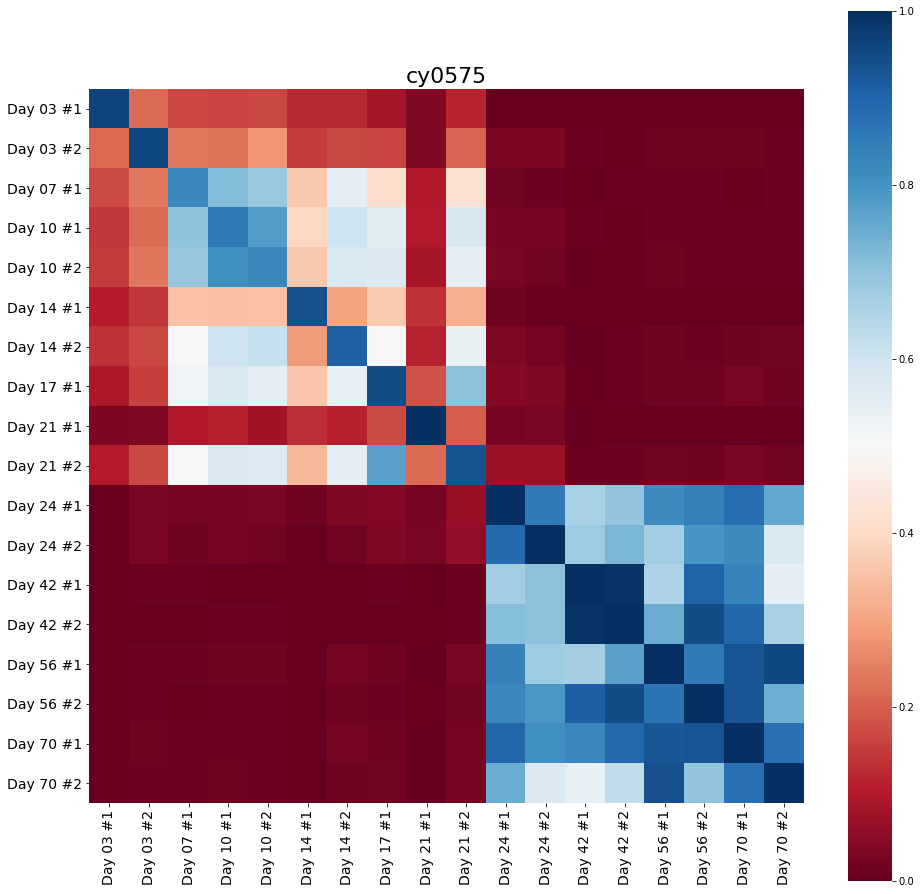

In [335]:
def heatmap(): 
    df = pd.read_csv(mhFolder + "/" + "mhExperimentalMatrix_2000reads_" + str(replicates) + "reps_" + animal2name + ".csv", index_col = [0])
    plt.figure(figsize = (16,16))
    plt.xticks(rotation=90, fontsize='14')
    plt.yticks(rotation=90, fontsize='14')
    plt.title(animal2name, fontsize='22')
    heatmap2 = sb.heatmap(df, cmap='RdBu', robust=True, square=True, vmin=0.0, vmax=1.0)
    
MHheatmap = heatmap()

# Wilcoxan Rank Sum Test--Animal 2

This section of the code is going to take the reference vs. the observed values for each cell of the above heatmap and it will compare them and provide a p-value. If the p-value is significant, we know that the two time points that that data came from are significantly different from one another. 

In [345]:
def WilcoxanRank2(): 
    #open the reference heatmap grid
    ref = pd.read_csv(mhFolder + "/mhReferenceMatrix_2000reads_" + str(replicates) + "reps_" + animal2name + ".csv", 
                     index_col = [0], low_memory = False)
    
    #open the experimental heatmap grid
    exp = pd.read_csv(mhFolder + "/mhExperimentalMatrix_2000reads_" + str(replicates) + "reps_" + animal2name + ".csv", 
                     index_col = [0], low_memory = False)
    
    #converting the reference heatmap to a numpy array
    ref_np = ref.to_numpy()
    
    #converting the experimental heatmap to a numpy array
    exp_np = exp.to_numpy()
    
    #doing wilcoxan-rank sum test
    WRS = scipy.stats.ranksums(ref_np, exp_np)
    print(WRS)
    
WR2 = WilcoxanRank2()

RanksumsResult(statistic=246.43305429720718, pvalue=0.0)


# Computing Total Barcodes and Unique Barcode Identities

This is going to compute the total barcodes found and total unique barcodes found as well 

In [13]:
def total_barcodes_and_uniques():
    
    #this is the empty list that we will put each sample's total value in
    totals = []
    
    #this is the empty list that we will put each sample's unique barcode value in
    uniques = []
    
    #this is the empty list that we will put barcode proportions in so we can find the lowest one for the paper
    proportions = []
    
    #walking through the summary spreadsheet directory
    for root, dirs, files in os.walk(summarySpreadsheetDirectory):
        #take the next directory in the list
        for dir1 in dirs:
            #lists all of the files in the directory we just chose
            directory = os.listdir(summarySpreadsheetDirectory + "/" + dir1)
            #looks through the files in the directory
            for f in directory: 
                #searches for the spreadsheets that start with 2 only since this is the one that we want
                if f.startswith("1_"): 
                    #reads this file into a pandas dataframe 
                    df = pd.read_csv(summarySpreadsheetDirectory + "/" + dir1 + "/" + f)
                    #finds the total number of barcodes in the spreadsheet
                    total1 = df['Counts'].sum()
                    #adds this value to the totals
                    totals.append(total1)
                    
                    #now we are going to get our unique barcodes by totaling the number of rows
                    #it automatically subtracts the first row since it's the "index" row so we don't need to subtract one
                    
                    #this is the number of rows in the spreadsheet minus the first (which is the index anyway)
                    length = len(df.index)
                    #adds this value to the uniques list to be used later
                    uniques.append(length)
                    
                    
    maximum = max(totals)
    minimum = min(totals)
    
    maximum_uniques = max(uniques)
    minimum_uniques = min(uniques)

    
    print("We are looking at all of the barcode values from this directory:\n")
    print(summarySpreadsheetDirectory)
    print("\nTotal barcode values from all samples in this directory:\n")
    print(totals)
    print("\nThis is the maximum value from this list:\n")
    print(maximum)
    print("\nThis is the minimum value from this list:\n")
    print(minimum)
    print("\nThis is the number of unique barcodes from this list:\n")
    print(uniques)
    print("\nThis is the maximum number of unique barcodes from this list:\n")
    print(maximum_uniques)
    print("\nThis is the minimum number of unique barcodes from this list:\n")
    print(minimum_uniques)

    
        
totals = total_barcodes_and_uniques()

We are looking at all of the barcode values from this directory:

/Users/agolfinos/Desktop/Research_Projects/IR_SDI_Analysis_exp5146/Step6.75.AllReplicatesToBeUsed

Total barcode values from all samples in this directory:

[57926.0, 57428.0, 88968.0, 58578.0, 71468.0, 80745.0, 65728.0, 67370.0, 61285.0, 95502.0, 103828.0, 56078.0, 57231.0, 74323.0, 74767.0, 89649.0]

This is the maximum value from this list:

103828.0

This is the minimum value from this list:

56078.0

This is the number of unique barcodes from this list:

[15, 4, 6, 4, 21, 5, 19, 23, 25, 5, 7, 5, 5, 12, 11, 30]

This is the maximum number of unique barcodes from this list:

30

This is the minimum number of unique barcodes from this list:

4


# Pre-Scatter Plot Data Manipulation Animal 1

This section of the code is going to take all of the individual files in for each animal and combine them into one file that it organized by time point (x-axis), as well as by barcode (each of the individual points for the graph), and by frequency (y-axis value). We need to do this using pandas merging techniques, and then we need to try to convert the table so that it is then usable with this type of graph. The graph itself will be created using seaborn .catplot(). 

In [279]:
def pre_cat_scat_plot(): 
    
    #make a list of all of the file names so we can use it for an index column and row later on
    file_names = []
    
    #an empty list so that we can assign each of the dataframes to this list and join them later
    dfs = []
    
    for i in animal_1_folders: 
        
        #splitting the path name so we can make a list of all the samples as we iterate through the files
        split_i = re.split('/', i)
        
        #keep the last element of the split_i list
        sampleName = split_i[-1]
        
        #split this new string by the underscore and store it as a list
        split_sN = re.split(' ', sampleName)
        
        #keeping the second, third and fourth element of this list, which are the week and the day names and rep #
        point = split_sN[1:4]
        
        #join these with a space so we can use it as x-axis labels
        time_point = ' '.join(point)
        
        #adding the file name to the list of filenames to use later for an index column and row
        file_names.append(sampleName)
        
        #creates a list of all of the files in this directory
        directory = os.listdir(i)
        
        #filtering the list for only the second spreadsheet, which is the only one we will be using
        for s in directory: 
            #only keep the first file, which has counts but not percentages
            if s.startswith('1_'):
                
                #assigning the file to a variable
                first_file = s
                
                #read the csv in as a pandas dataframe 
                df = pd.read_csv(i + "/" + first_file, index_col = [0])
                
                #adding a column with the time point, which is needed for the subsequent analysis
                df["Time_Point"] = time_point
                
                #add this dataframe to the list of dataframes
                dfs.append(df)
    
    #this combines all of the dataframes in the dfs list together for one large dataframe for this animal
    df_final = pd.concat(dfs)
    df_final.sort_values(by=['Time_Point'], ascending=True, inplace=True)
    print(df_final)
    df_final.to_csv(cat_scatter_plot_directory + "/Joined_barcodes_" + animal1name + ".csv")

#at this time, make sure that everything looks correct before you plot the graph. Open the file to make sure
    
    

        
yay_data = pre_cat_scat_plot()        

                  Counts Time_Point
Barcode                            
SIVmac239M.2579      2.0  Day 03 #1
SIVmac239M.6537    311.0  Day 03 #1
SIVmac239M.74      279.0  Day 03 #1
SIVmac239M.1366    284.0  Day 03 #1
SIVmac239M.6980    285.0  Day 03 #1
SIVmac239M.1463    288.0  Day 03 #1
SIVmac239M.441     291.0  Day 03 #1
SIVmac239M.2389    299.0  Day 03 #1
SIVmac239M.3466    302.0  Day 03 #1
SIVmac239M.1371    304.0  Day 03 #1
SIVmac239M.4569    275.0  Day 03 #1
SIVmac239M.2621    310.0  Day 03 #1
SIVmac239M.3601     17.0  Day 03 #1
SIVmac239M.200       4.0  Day 03 #1
SIVmac239M.13        2.0  Day 03 #1
SIVmac239M.13098     2.0  Day 03 #1
SIVmac239M.13440     2.0  Day 03 #1
SIVmac239M.10094     2.0  Day 03 #1
SIVmac239M.10358     3.0  Day 03 #1
SIVmac239M.9526      3.0  Day 03 #1
SIVmac239M.317     311.0  Day 03 #1
SIVmac239M.3980     26.0  Day 03 #1
SIVmac239M.121     274.0  Day 03 #1
SIVmac239M.394     271.0  Day 03 #1
SIVmac239M.4214    271.0  Day 03 #1
SIVmac239M.921     129.0  Da

# Scatter Plot Animal 1

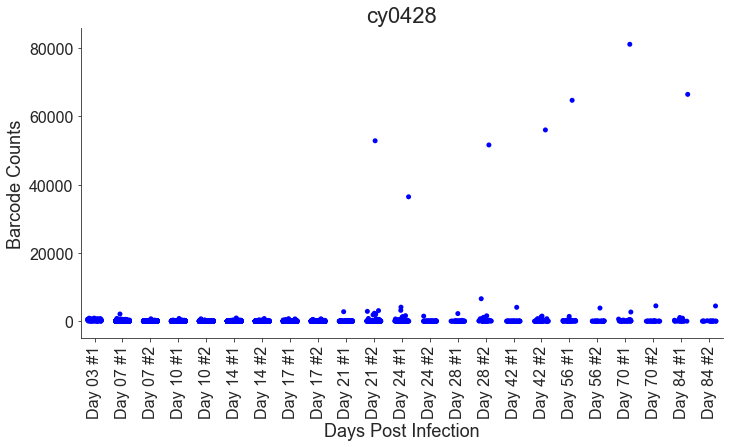

In [281]:
def cat_scat_plot():
    
#import data from the csv file
    df = pd.read_csv(cat_scatter_plot_directory + "/Joined_barcodes_" + animal1name + ".csv")
    
    #actually plotting the data
    fig = sb.catplot(x='Time_Point', y="Counts", data=df, jitter='0.25', color='b', height=5, aspect=2)
    sb.set_style("ticks")
    plt.xticks(rotation=90, fontsize='16')
    plt.yticks(fontsize='16')
    plt.xlabel('Days Post Infection', fontsize=18)
    plt.ylabel('Barcode Counts', fontsize=18)
    plt.title(animal1name, fontsize='22')
    
    

woo_scatterplot = cat_scat_plot()    

# Pre-Scatter Plot Data Manipulation Animal 2

In [276]:
def pre_cat_scat_plot2(): 
    
    #make a list of all of the file names so we can use it for an index column and row later on
    file_names = []
    
    #an empty list so that we can assign each of the dataframes to this list and join them later
    dfs = []
    
    for i in animal_2_folders: 

        #splitting the path name so we can make a list of all the samples as we iterate through the files
        split_i = re.split('/', i)

        #keep the last element of the split_i list
        sampleName = split_i[-1]

        #split this new string by the underscore and store it as a list
        split_sN = re.split(' ', sampleName)
        
        #keeping the second and third element of this list, which are the week and the day names
        point = split_sN[1:4]
        
        #join these with a space so we can use it as x-axis labels
        time_point = ' '.join(point)
        
        #adding the file name to the list of filenames to use later for an index column and row
        file_names.append(sampleName)
        
        #creates a list of all of the files in this directory
        directory = os.listdir(i)
        
        #filtering the list for only the second spreadsheet, which is the only one we will be using
        for s in directory: 
            #only keep the first file, which has counts but not percentages
            if s.startswith('1_'):
                
                #assigning the file to a variable
                first_file = s
                
                #read the csv in as a pandas dataframe 
                df = pd.read_csv(i + "/" + first_file, index_col = [0])
                
                #adding a column with the time point, which is needed for the subsequent analysis
                df["Time_Point"] = time_point
                
                #add this dataframe to the list of dataframes
                dfs.append(df)
    
    #this combines all of the dataframes in the dfs list together for one large dataframe for this animal
    df_final = pd.concat(dfs)
    df_final.sort_values(by=['Time_Point'], ascending=True, inplace=True)
    print(df_final)
    df_final.to_csv(cat_scatter_plot_directory + "/Joined_barcodes_" + animal2name + ".csv")

#at this time, make sure that everything looks correct before you plot the graph. Open the file to make sure
          
yay_data2 = pre_cat_scat_plot2()        

                   Counts Time_Point
Barcode                             
SIVmac239M.6818    1528.0  Day 03 #1
SIVmac239M.1098     379.0  Day 03 #1
SIVmac239M.5180     378.0  Day 03 #1
SIVmac239M.6319     377.0  Day 03 #1
SIVmac239M.6419     375.0  Day 03 #1
SIVmac239M.1356     373.0  Day 03 #1
SIVmac239M.236      373.0  Day 03 #1
SIVmac239M.754      367.0  Day 03 #1
SIVmac239M.474      355.0  Day 03 #1
SIVmac239M.2254     354.0  Day 03 #1
SIVmac239M.44       346.0  Day 03 #1
SIVmac239M.76       344.0  Day 03 #1
SIVmac239M.363      344.0  Day 03 #1
SIVmac239M.5532     343.0  Day 03 #1
SIVmac239M.2918     340.0  Day 03 #1
SIVmac239M.2937     330.0  Day 03 #1
SIVmac239M.1089     325.0  Day 03 #1
SIVmac239M.1442     319.0  Day 03 #1
SIVmac239M.481      317.0  Day 03 #1
SIVmac239M.790      312.0  Day 03 #1
SIVmac239M.4397     309.0  Day 03 #1
SIVmac239M.8        307.0  Day 03 #1
SIVmac239M.2212     389.0  Day 03 #1
SIVmac239M.5605     303.0  Day 03 #1
SIVmac239M.3826     389.0  Day 03 #1
S

# Scatter Plot Animal 2

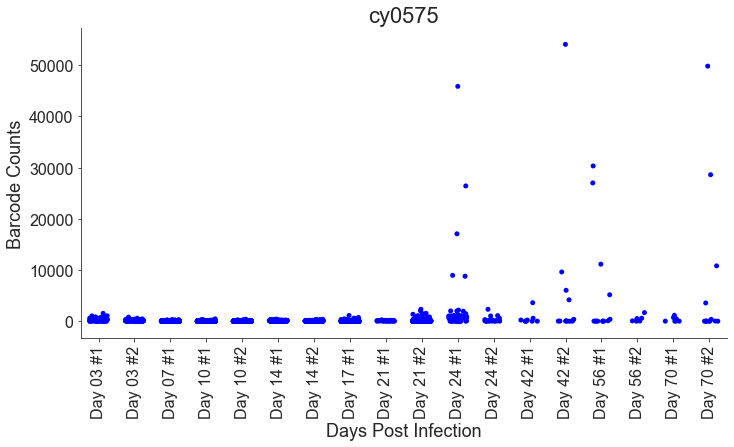

In [278]:
def cat_scat_plot2():
    
#import data from the csv file
    df = pd.read_csv(cat_scatter_plot_directory + "/Joined_barcodes_" + animal2name + ".csv")
    
    #actually plotting the data
    fig = sb.catplot(x='Time_Point', y="Counts", data=df, jitter='0.25', color='b', height=5, aspect=2)
    sb.set_style("ticks")
    plt.xticks(rotation=90, fontsize='16')
    plt.yticks(fontsize='16')
    plt.xlabel('Days Post Infection', fontsize=18)
    plt.ylabel('Barcode Counts', fontsize=18)
    plt.title(animal2name, fontsize='22')
    
    

woo_scatterplot2 = cat_scat_plot2()    

# Extracting Epitopes--Animal 1

This portion of the code is going to take the trimmed fastq files, and it's going to return a list of Nef RM9 epitopes found in this file. 

In [ ]:
def extractingEpitopes1(): 
    for root, dirs, files in os.walk(trimmedReads): 
        for f in files: 
            for record in SeqIO.parse(f, "fastq"): 
                print(record.id)
                
Epitopes1 = extractingEpitopes1()